<div id="container" style="position:relative;">
<div style="float:left"><h1> Sprint 2 </h1></div>
<div style="position:relative; float:right">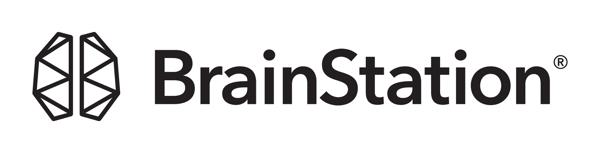
</div>
</div>


***

**Author:** Matt Bonadies  
**Date:** 4-2-2024  
**Version:** JupyterLab 3.6.3  
**Kernel:** Deeplearning from BrainStation

***

## Project Overview

#### **Introduction**  

The goal of this project is to create a machine learning model that takes historical data from the PGA (Professional Golf Association) Tour and predicts the scores any given player will shoot in their next tournament based on their past performance. While the predictions have a broad range of applications, our primary focus will be on their utility in the context of sports betting. This notebook pertains to the second sprint of my project. In Sprint 1, we explored the initial data source and conducted a preliminary Exploratory Data Analysis (EDA) to gauge the feasibility of creating a machine learning model. In Sprint 2, we will reexamine the project's fundamentals and the data, in addition to presenting the EDA and initial models. If you're interested in reviewing my Sprint 1 work, both the notebook and the presentation are available on my GitHub (https://github.com/matthewbonadies/BrainStation_Capstone). Before we proceed, let's take a moment to go over the basics underlying this project, including an understanding of golf, the PGA Tour, and sports betting.

#### **What is Golf?**  

Golf is a sport played on vast outdoor courses, each featuring 18 holes scattered across several thousand yards. Players aim to sink the ball in each hole using the minimum strokes possible. The game's simplicity in objective masks its strategic depth, requiring a wide range of shots from long drives to short, precise chips. Courses include Par 3's, Par 4's, and Par 5's, with the Par number indicating the expected number of strokes to complete the hole, from the starting point, or Tee Box, to the hole which is located on the putting green. The combination of these holes sets a standard course par, usually at 72 strokes, against which players' performances are measured.

#### **Youtube Videos for Further Explanation**

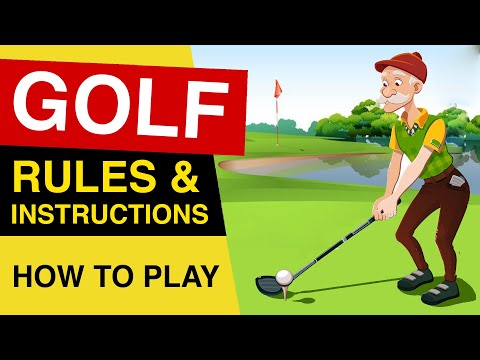

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo('99nN7WWNF1Q')

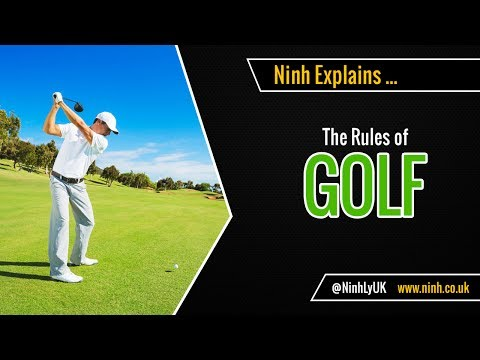

In [2]:
YouTubeVideo('IcaFTHeVQ7w')

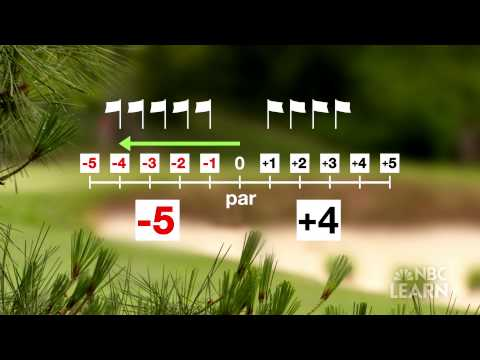

In [3]:
YouTubeVideo('UO4Zri-H3AE')

#### **What is the PGA Tour?**  

At the pinnacle of this sport is the PGA Tour, where around 120 competitors partake in a four-day tournament, playing one round daily from Thursday to Sunday. The winner is the player with the lowest total strokes. Distinguished from many sports by its non-stop calendar, the PGA Tour introduces a new event every week in varied locations, continuously presenting fresh challenges and engaging spectators with its dynamic blend of competition and changing landscapes.

#### **What is Sports Betting?**

Sports betting is a form of gambling where individuals place wagers on the outcome of various sports events. Unlike many other forms of gambling that are purely chance-based, sports betting can involve a degree of skill and knowledge about the sports, teams, and athletes involved. Here’s a basic breakdown of how sports betting works:
  
- **Odds**: Odds represent the likelihood of an event happening. They determine how much a bettor can win if their bet is successful.
- **Types of Bets**: There are many types of bets that can be placed, ranging from simple bets on which team will win a game (Moneyline Bets) to more complex bets involving the margin of victory (Point Spread Bets) or the total points scored (Over/Under Bets).
- **How to Bet**: Bets can be placed through various channels, including online betting apps and traditional brick-and-mortar casinos.
  
Successful bettors research teams, analyze statistics, and follow sports news closely to make informed decisions. While there's always an element of luck involved, having a well-thought-out strategy can improve one's chances of winning.

#### **What is Golf Betting?**

Golf betting involves placing wagers on various outcomes related to golf tournaments. Unlike team sports, golf is an individual sport, which adds unique elements to betting. Here's an overview of the most common golf bets:
  
 - **Tournament Winner**: Betting on a player to win the tournament outright. It's straightforward but challenging due to the large field.
 - **Top 5, 10, 20 Finish**: Wagering on a player to finish in the top 5, 10, or 20. Offers lower odds than betting on the winner but is a bit easier to predict.
 - **Head-to-Head Matchups**: This involves betting on one player to outperform another specific player. The focus is on the overall performance rather than just the top positions. This method is most similar to betting in other sports, where you predict the outcome between two competing teams.

#### **Final Thoughts**

With the context of this project established, it's evident that developing a machine learning model to forecast a player's score **(Our Target Variable)** could be valuable. Such a model can guide bettors on the likely outcomes of various bets tied to a player's score, which, as mentioned earlier, are among the most frequent types of bets.

***

## Table of Contents

- **Imports**
- **Data Retrievel**
- **Data Dictionary**
- **Train Data Preparation**
    - Preprocessing
    - Feature Engineering
- **Test Data Preparation**
    - Preprocessing
    - Feature Engineering
- **Exploratory Data Analysis**
- **Modelling**
    - Linear Regression
    - Ridge Regression
    - Lasso Regression
    - Linear Pipeline
    - Random Forest Regressor
    - Neural Network

***

## Imports

In [4]:
# Imports all of the libraries that will be utilized throughout this project
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from datetime import datetime, timedelta
from io import StringIO
import requests

In [5]:
# Imports all of the scikit-Learn libraries that will be utilized throughout this project
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge, Lasso
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import fetch_california_housing
from sklearn.neural_network import MLPRegressor
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from sklearn.metrics import r2_score

In [6]:
# Enables view of all columns when viewing Pandas DataFrames
pd.set_option('display.max_columns', None)

***

## Data Retrieval

We are going to retrieve three different data tables from the datagolf API:

1. Round Scoring, Stats & Strokes Gained
2. Player List & IDs
3. Field Updates

At the start of our process, we separate the data into training and testing datasets due to the data's time-sensitive aspect. This separation is crucial to avoid data leakage during the feature engineering phase. Prior to our preprocessing and feature engineering efforts, we've included a data dictionary to offer a more detailed explanation of the data.

In [7]:
# Private API Key utilized in the paramater variables below to extract data
api_key = ''

#### Round Scoring, Stats, & Strokes Gained - Training Dataset Retrieval

In [8]:
# Retrieves Training Data
api_url = "https://feeds.datagolf.com/historical-raw-data/rounds"

df_list = []

for year in range (2017, 2022):
    params = {
        'tour': 'pga',
        'event_id': 'all',
        'year': year,
        'file_format': 'csv',
        'key': api_key
    }

    response = requests.get(api_url, params=params)

    if response.status_code == 200:
        # Use StringIO to convert the response content into a file-like object for read_csv
        data = StringIO(response.text)
        df = pd.read_csv(data)
        df_list.append(df)
        print(f"Data added for year: {year}")
    else:
        print("Failed to fetch data from the API. Status code:", response.status_code)

tn_df = pd.concat(df_list, ignore_index=True)

print("Train Data Retrieved!")

Data added for year: 2017
Data added for year: 2018
Data added for year: 2019
Data added for year: 2020
Data added for year: 2021
Train Data Retrieved!


#### Round Scoring, Stats, & Strokes Gained - Testing Dataset Retrieval

In [9]:
# Retrieves Testing Data
api_url = "https://feeds.datagolf.com/historical-raw-data/rounds"

df_list = []

for year in range (2022, 2025):
    params = {
        'tour': 'pga',
        'event_id': 'all',
        'year': year,
        'file_format': 'csv',
        'key': api_key
    }

    response = requests.get(api_url, params=params)

    if response.status_code == 200:
        # Use StringIO to convert the response content into a file-like object for read_csv
        data = StringIO(response.text)
        df = pd.read_csv(data)
        df_list.append(df)
        print(f"Data added for year: {year}")
    else:
        print("Failed to fetch data from the API. Status code:", response.status_code)

tt_df = pd.concat(df_list, ignore_index=True)

print("Test Data Retrieved!")

Data added for year: 2022
Data added for year: 2023
Data added for year: 2024
Test Data Retrieved!


#### Player List & IDs Dataset Retrieval

In [10]:
# Retrieves Player Information Data
api_url = "https://feeds.datagolf.com/get-player-list"

params = {
    'file_format': 'csv',
    'key': api_key
}

response = requests.get(api_url, params=params)

if response.status_code == 200:
    # Use StringIO to convert the response content into a file-like object for read_csv
    data = StringIO(response.text)
    player_df = pd.read_csv(data)
    print("Player Data Retrieved!")
else:
    print("Failed to fetch data from the API. Status code:", response.status_code)

Player Data Retrieved!


#### Field Updates Dataset Retrieval

In [11]:
# Retrieves Player and Tournament Information Data for the Current Week
api_url = 'https://feeds.datagolf.com/field-updates'

params = {
    'tour': 'pga',
    'file_format': 'csv',
    'key': api_key
}

response = requests.get(api_url, params=params)

if response.status_code == 200:
    # Use StringIO to convert the response content into a file-like object for read_csv
    data = StringIO(response.text)
    field_df = pd.read_csv(data)
    print("Tournament Data Retrieved!")
else:
    print("Failed to fetch data from the API. Status code:", response.status_code)

Tournament Data Retrieved!


In [12]:
# Makes copies of the original dataframes
train_df = tn_df.copy()
test_df = tt_df.copy()

***

## Data Dictionary

#### **Round Scoring, Stats, & Strokes Gained**

| Column | Type | Description |
| --- | --- | --- |
| tour | object | Professional tour that the event was played on. |
| year | int64 | Calendar year. |
| season | int64 | Official season as defined by the PGA tour. |
| event_completed | datetime64[ns] | Official date of the final round of the tournament  |
| event_name | object | Name of tournament. |
| event_id | int64 | Unique Tournament ID number. |
| player_name | object | Name of player. |
| dg_id | int64 | Unique Player ID number. There is a single dg_id for each player. |
| round_num | int64 | Round number for the given tournament. Ranges from 1-4. |
| course_name | object | Name of golf course. |
| course_num | int64 | Unique Course ID number. |
| course_par | int64 | Course par - Scoring benchmark. Value is typically 72, but it can range from 70 to 72. |
| start_hole | int64 | Hole number that player started on. Value is either 1 or 10. |
| round_score | int64 | Score that was shot for the given round. Our model’s target variable. |
| sg_putt | float64 | Strokes gained putting.  |
| sg_arg | float64 | Strokes gained around the green.  |
| sg_app | float64 | Strokes gained approaching the green. |
| sg_ott | float64 | Strokes gained off the tee. |
| sg_t2g | float64 | Strokes gained from tee to green. The sum of sg_ott, sg_app, and sg_arg. |
| sg_total | float64 | Strokes gained total. Difference between the player’s score and the average score. |
| driving_dist | float64 | Average distance of every drive hit. |
| driving_acc | float64 | Fairways in regulation. Percentage of fairways. |
| gir | float64 | Greens in regulation. Percentage of greens hit. |
| scrambling | float64 | Percentage of shots  ≤ 50 yards that were holed out in 2 strokes or less. |
| prox_rgh | float64 | Average proximity of all shots hit from locations other than the fairway. |
| prox_fw | float64 | Average proximity of all shots hit from the fairway. |
| great_shots | float64 | Sum of shots that fall into the top 5% of strokes-gained values in each category. |
| poor_shots | float64 | Sum of shots that fall into the bottom 5% of strokes-gained values in each category. |
| fin_num | int64 | Official finishing position. |
| teetime_numeric | float64 | Time a player tee’d off. |
| round_completed | datetime64[ns] | Date the round was played. |
| month | int32 | Month the round was played. |
| day | int32 | Day of month the round was played. |
| ohe_win | int64 | Binary value if the player won or not. |
| ohe_top_five | int64 | Binary value if the player finished in the top 5 or not. |
| ohe_top_ten | int64 | Binary value if the player finished in the top 10 or not. |
| ohe_top_twenty | int64 | Binary value if the player finished in the top 20 or not. |
| ohe_make_cut | int64 | Binary value if the player made the cut after 2 rounds or not. |
| L20_moving_avg_sg_putt | float64 | Average strokes gained putting from the last 20 rounds. |
| L16_moving_avg_sg_putt | float64 | Average strokes gained putting from the last 16 rounds. |
| L12_moving_avg_sg_putt | float64 | Average strokes gained putting from the last 12 rounds. |
| L8_moving_avg_sg_putt | float64 | Average strokes gained putting from the last 8 rounds. |
| L4_moving_avg_sg_putt | float64 | Average strokes gained putting from the last 4 rounds. |
| L20_moving_avg_sg_arg | float64 | Average strokes gained around the green from the last 20 rounds. |
| L16_moving_avg_sg_arg | float64 | Average strokes gained around the green from the last 16 rounds. |
| L12_moving_avg_sg_arg | float64 | Average strokes gained around the green from the last 12 rounds. |
| L8_moving_avg_sg_arg | float64 | Average strokes gained around the green from the last 8 rounds. |
| L4_moving_avg_sg_arg | float64 | Average strokes gained around the green from the last 4 rounds. |
| L20_moving_avg_sg_app | float64 | Average strokes gained approaching the green from the last 20 rounds. |
| L16_moving_avg_sg_app | float64 | Average strokes gained approaching the green from the last 16 rounds. |
| L12_moving_avg_sg_app | float64 | Average strokes gained approaching the green from the last 12 rounds. |
| L8_moving_avg_sg_app | float64 | Average strokes gained approaching the green from the last 8 rounds. |
| L4_moving_avg_sg_app | float64 | Average strokes gained approaching the green from the last 4 rounds. |
| L20_moving_avg_sg_ott | float64 | Average strokes gained off the tee from the last 20 rounds. |
| L16_moving_avg_sg_ott | float64 | Average strokes gained off the tee from the last 16 rounds. |
| L12_moving_avg_sg_ott | float64 | Average strokes gained off the tee from the last 12 rounds. |
| L8_moving_avg_sg_ott | float64 | Average strokes gained off the tee from the last 8 rounds. |
| L4_moving_avg_sg_ott | float64 | Average strokes gained off the tee from the last 4 rounds. |
| L20_moving_avg_sg_t2g | float64 | Average strokes gained tee to green from the last 20 rounds. |
| L16_moving_avg_sg_t2g | float64 | Average strokes gained tee to green from the last 16 rounds. |
| L12_moving_avg_sg_t2g | float64 | Average strokes gained tee to green from the last 12 rounds. |
| L8_moving_avg_sg_t2g | float64 | Average strokes gained tee to green from the last 8 rounds. |
| L4_moving_avg_sg_t2g | float64 | Average strokes gained tee to green from the last 4 rounds. |
| L20_moving_avg_sg_total | float64 | Average strokes gained total from the last 20 rounds. |
| L16_moving_avg_sg_total | float64 | Average strokes gained total from the last 16 rounds. |
| L12_moving_avg_sg_total | float64 | Average strokes gained total from the last 12 rounds. |
| L8_moving_avg_sg_total | float64 | Average strokes gained total from the last 8 rounds. |
| L4_moving_avg_sg_total | float64 | Average strokes gained total from the last 4 rounds. |
| L20_moving_avg_driving_dist | float64 | Average driving distance from the last 20 rounds. |
| L16_moving_avg_driving_dist | float64 | Average driving distance from the last 16 rounds. |
| L12_moving_avg_driving_dist | float64 | Average driving distance from the last 12 rounds. |
| L8_moving_avg_driving_dist | float64 | Average driving distance from the last 8 rounds. |
| L4_moving_avg_driving_dist | float64 | Average driving distance from the last 4 rounds. |
| L20_moving_avg_driving_acc | float64 | Average driving accuracy from the last 20 rounds. |
| L16_moving_avg_driving_acc | float64 | Average driving accuracy from the last 16 rounds. |
| L12_moving_avg_driving_acc | float64 | Average driving accuracy from the last 12 rounds. |
| L8_moving_avg_driving_acc | float64 | Average driving accuracy from the last 8 rounds. |
| L4_moving_avg_driving_acc | float64 | Average driving accuracy from the last 4 rounds. |
| L20_moving_avg_gir | float64 | Average GIR from the last 20 rounds. |
| L16_moving_avg_gir | float64 | Average GIR from the last 16 rounds. |
| L12_moving_avg_gir | float64 | Average GIR from the last 12 rounds. |
| L8_moving_avg_gir | float64 | Average GIR from the last 8 rounds. |
| L4_moving_avg_gir | float64 | Average GIR from the last 4 rounds. |
| L20_moving_avg_scrambling | float64 | Average scrambling from the last 20 rounds. |
| L16_moving_avg_scrambling | float64 | Average scrambling from the last 16 rounds. |
| L12_moving_avg_scrambling | float64 | Average scrambling from the last 12 rounds. |
| L8_moving_avg_scrambling | float64 | Average scrambling from the last 8 rounds. |
| L4_moving_avg_scrambling | float64 | Average scrambling from the last 4 rounds. |
| career_avg | float64 | Career scoring average. |
| L20_moving_avg | float64 | Scoring average from last 20 rounds. |
| L16_moving_avg | float64 | Scoring average from last 16 rounds. |
| L12_moving_avg | float64 | Scoring average from last 12 rounds. |
| L8_moving_avg | float64 | Scoring average from last 8 rounds. |
| L4_moving_avg | float64 | Scoring average from last 4 rounds. |
| career_min | float64 | Lowest score shot in career. |
| L20_moving_min | float64 | Lowest score from last 20 rounds. |
| L16_moving_min | float64 | Lowest score from last 16 rounds. |
| L12_moving_min | float64 | Lowest score from last 12 rounds. |
| L8_moving_min | float64 | Lowest score from last 8 rounds. |
| L4_moving_min | float64 | Lowest score from last 4 rounds. |
| career_max | float64 | Highest score shot in career. |
| L20_moving_max | float64 | Highest score from last 20 rounds. |
| L16_moving_max | float64 | Highest score from last 16 rounds. |
| L12_moving_max | float64 | Highest score from last 12 rounds. |
| L8_moving_max | float64 | Highest score from last 8 rounds. |
| L4_moving_max | float64 | Highest score from last 4 rounds. |
| L20_round_score_std_dev | float64 | Standard deviation of scores from last 20 rounds. |
| L16_round_score_std_dev | float64 | Standard deviation of scores from last 16 rounds. |
| L12_round_score_std_dev | float64 | Standard deviation of scores from last 12 rounds. |
| L8_round_score_std_dev | float64 | Standard deviation of scores from last 8 rounds. |
| L4_round_score_std_dev | float64 | Standard deviation of scores from last 4 rounds. |
| L20_sg_putt_std_dev | float64 | Standard deviation of strokes gained putting from the last 20 rounds. |
| L16__sg_putt_std_dev | float64 | Standard deviation of strokes gained putting from the last 16 rounds. |
| L12_putt_std_dev | float64 | Standard deviation of strokes gained putting from the last 12 rounds. |
| L8_putt_std_dev | float64 | Standard deviation of strokes gained putting from the last 8 rounds. |
| L4_sg_putt_std_dev | float64 | Standard deviation of strokes gained putting from the last 4 rounds. |
| L20_sg_arg_std_dev | float64 | Standard deviation of strokes gained around the green from the last 20 rounds. |
| L16_sg_arg_std_dev | float64 | Standard deviation of strokes gained around the green from the last 16 rounds. |
| L12_sg_arg_std_dev | float64 | Standard deviation of strokes gained around the green from the last 12 rounds. |
| L8_sg_arg_std_dev | float64 | Standard deviation of strokes gained around the green from the last 8 rounds. |
| L4_sg_arg_std_dev | float64 | Standard deviation of strokes gained around the green from the last 4 rounds. |
| L20_sg_app_std_dev | float64 | Standard deviation of strokes gained approaching the green from the last 20 rounds. |
| L16_app_std_dev | float64 | Standard deviation of strokes gained approaching the green from the last 16 rounds. |
| L12_app_std_dev | float64 | Standard deviation of strokes gained approaching the green from the last 12 rounds. |
| L8_sg_app_std_dev | float64 | Standard deviation of strokes gained approaching the green from the last 8 rounds. |
| L4_sg_app_std_dev | float64 | Standard deviation of strokes gained approaching the green from the last 4 rounds. |
| L20_sg_ott_std_dev | float64 | Standard deviation of strokes gained off the tee from the last 20 rounds. |
| L16_sg_ott_std_dev | float64 | Standard deviation of strokes gained off the tee from the last 16 rounds. |
| L12_sg_ott_std_dev | float64 | Standard deviation of strokes gained off the tee from the last 12 rounds. |
| L8_sg_ott_std_dev | float64 | Standard deviation of strokes gained off the tee from the last 8 rounds. |
| L4_sg_ott_std_dev | float64 | Standard deviation of strokes gained off the tee from the last 4 rounds. |
| L20_sg_t2g_std_dev | float64 | Standard deviation of strokes gained tee to green from the last 20 rounds. |
| L16_sg_t2g_std_dev | float64 | Standard deviation of strokes gained tee to green from the last 16 rounds. |
| L12_sg_t2g_std_dev | float64 | Standard deviation of strokes gained tee to green from the last 12 rounds. |
| L8_sg_t2g_std_dev | float64 | Standard deviation of strokes gained tee to green from the last 8 rounds. |
| L4_sg_t2g_std_dev | float64 | Standard deviation of strokes gained tee to green from the last 4 rounds. |
| L20_sg_total_std_dev | float64 | Standard deviation of strokes gained total from the last 20 rounds. |
| L16_sg_total_std_dev | float64 | Standard deviation of strokes gained total from the last 16 rounds. |
| L12_sg_total_std_dev | float64 | Standard deviation of strokes gained total from the last 12 rounds. |
| L8_total_std_dev | float64 | Standard deviation of strokes gained total from the last 8 rounds. |
| L4_sg_total_std_dev | float64 | Standard deviation of strokes gained total from the last 4 rounds. |
| L20_driving_dist_std_dev | float64 | Standard deviation of driving distance from the last 20 rounds. |
| L16_driving_dist_std_dev | float64 | Standard deviation of driving distance from the last 16 rounds. |
| L12_driving_dist_std_dev | float64 | Standard deviation of driving distance from the last 12 rounds. |
| L8_driving_dist_std_dev | float64 | Standard deviation of driving distance from the last 8 rounds. |
| L4_driving_dist_std_dev | float64 | Standard deviation of driving distance from the last 4 rounds. |
| L20_driving_acc_std_dev | float64 | Standard deviation of driving accuracy from the last 20 rounds. |
| L16_driving_acc_std_dev | float64 | Standard deviation of driving accuracy from the last 16 rounds. |
| L12_driving_acc_std_dev | float64 | Standard deviation of driving accuracy from the last 12 rounds. |
| L8_driving_acc_std_dev | float64 | Standard deviation of driving accuracy from the last 8 rounds. |
| L4_driving_acc_std_dev | float64 | Standard deviation of driving accuracy from the last 4 rounds. |
| L20_gir_std_dev | float64 | Standard deviation of GIR from the last 20 rounds. |
| L16_gir_std_dev | float64 | Standard deviation of GIR from the last 16 rounds. |
| L12_gir_std_dev | float64 | Standard deviation of GIR from the last 12 rounds. |
| L8_gir_std_dev | float64 | Standard deviation of GIR from the last 8 rounds. |
| L4_gir_std_dev | float64 | Standard deviation of GIR from the last 4 rounds. |
| L20_scrambling_std_dev | float64 | Standard deviation of scrambling from the last 20 rounds. |
| L16_scrambling_std_dev | float64 | Standard deviation of scrambling from the last 16 rounds. |
| L12_scrambling_std_dev | float64 | Standard deviation of scrambling from the last 12 rounds. |
| L8_scrambling_std_dev | float64 | Standard deviation of scrambling from the last 8 rounds. |
| L4_scrambling_std_dev | float64 | Standard deviation of scrambling from the last 4 rounds. |
| Days_Since | int64 | Number of days between now and when the round was completed. |
| Last_365_Days | int64 | Binary column if round was played in the last 365 days or not. |
| Last_180_Days | int64 | Binary column if round was played in the last 180 days or not. |
| Last_90_Days | int64 | Binary column if round was played in the last 90 days or not. |
| Last_60_Days | int64 | Binary column if round was played in the last 60 days or not. |
| Last_30_Days | int64 | Binary column if round was played in the last 30 days or not. |
| Last_10_Days | int64 | Binary column if round was played in the last 10 days or not. |
| Last_5_Days | int64 | Binary column if round was played in the last 5 days or not. |
| lagged_year | float64 | Previous round year. |
| lagged_season | float64 | Previous round season. |
| lagged_event_id | float64 | Previous round event id. |
| lagged_round_num | float64 | Previous round number. |
| lagged_course_num | float64 | Previous round course number. |
| lagged_course_par | float64 | Previous round course par. |
| lagged_start_hole | float64 | Previous round start hole. |
| lagged_round_score | float64 | Previous round score. |
| lagged_sg_putt | float64 | Previous round strokes gained putting. |
| lagged_sg_arg | float64 | Previous round strokes gained around the green. |
| lagged_sg_app | float64 | Previous round strokes gained approaching the green. |
| lagged_sg_ott | float64 | Previous round strokes gained off the tee. |
| lagged_sg_t2g | float64 | Previous round strokes gained tee to green. |
| lagged_sg_total | float64 | Previous round strokes gained total. |
| lagged_driving_dist | float64 | Previous round average driving distance. |
| lagged_driving_acc | float64 | Previous round driving accuracy. |
| lagged_gir | float64 | Previous round greens in regulation. |
| lagged_scrambling | float64 | Previous round scrambling. |
| lagged_prox_rgh | float64 | Previous round average proximity of all shots hit from locations other than the fairway. |
| lagged_prox_fw | float64 | Previous round average proximity of all shots hit from the fairway. |
| lagged_great_shots | float64 | Previous round sum of great shots. |
| lagged_poor_shots | float64 | Previous round sum of poor shots. |
| lagged_month | float64 | Previous round month. |
| lagged_day | float64 | Previous round day of month. |
| lagged_fin_num | float64 | Previous round finishing position. |
| lagged_teetime_numeric | float64 | Previous round tee time. |
| lagged_ohe_win | float64 | Previous round binary value if the player won or not. |
| lagged_ohe_top_five | float64 | Previous round binary value if the player finished in the top 5 or not. |
| lagged_ohe_top_ten | float64 | Previous round binary value if the player finished in the top 10 or not. |
| lagged_ohe_top_twenty | float64 | Previous round binary value if the player finished in the top 20 or not. |
| lagged_ohe_make_cut | float64 | Previous round binary value if the player made the cut after 2 rounds or not. |

#### **Player List & IDs**

| Column | Type | Description |
| --- | --- | --- |
| player_name | object | Name of player. |
| dg_id | int64 | Unique Player ID number. There is a single dg_id for each player. |
| country | object | Country of player. |
| country_code | int64 | Numeric Country ID of player. |
| amateur | int64 | Binary column of whether a player is an amateur or not (Meaning they’re a professional if value is 0). |

#### **Field Updates**

| Column | Type | Description |
| --- | --- | --- |
| event_name | object | Name of tournament. |
| current_round | int64 | Upcoming round number. |
| course | float64 | Name of course. |
| player_name | object | Name of player. |
| dg_id | int64 | Unique Player ID number. There is a single dg_id for each player. |
| country | object | Country of player. |
| start_hole | int64 | Hole number that player started on. Value is either 1 or 10. |
| r1_teetime | float64 | Tee time of first round. |
| r2_teetime | float64 | Tee time of second round. |
| r3_teetime | float64 | Tee time of third round. |
| r4_teetime | float64 | Tee time of fourth round. |
| last_updated | object | Last time the table was refreshed. |
| early_late | int64 | Not pertinent for this project. |
| am | int64 | Not pertinent for this project. |
| flag | object | Not pertinent for this project. |
| pga_number | int64 | Not pertinent for this project. |
| yh_salary | int64 | Not pertinent for this project. |
| dk_salary | int64 | Not pertinent for this project. |
| fd_id | object | Not pertinent for this project. |
| fd_salary | int64 | Not pertinent for this project. |
| dk_id | int64 | Not pertinent for this project. |
| yh_id | object | Not pertinent for this project. |
| unofficial | int64 | Not pertinent for this project. |

####

***

## Training Data

### Preprocessing

In [13]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88266 entries, 0 to 88265
Data columns (total 30 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tour             88266 non-null  object 
 1   year             88266 non-null  int64  
 2   season           88266 non-null  int64  
 3   event_completed  88266 non-null  object 
 4   event_name       88266 non-null  object 
 5   event_id         88266 non-null  int64  
 6   player_name      88266 non-null  object 
 7   dg_id            88266 non-null  int64  
 8   fin_text         88266 non-null  object 
 9   round_num        88266 non-null  int64  
 10  course_name      88266 non-null  object 
 11  course_num       88266 non-null  int64  
 12  course_par       88266 non-null  int64  
 13  start_hole       88266 non-null  int64  
 14  teetime          88266 non-null  object 
 15  round_score      88266 non-null  int64  
 16  sg_putt          69306 non-null  float64
 17  sg_arg      

It appears we have some Null values, so let's look into them.

In [14]:
# Checks for null values in the dataframe
train_df.isna().sum()

tour                   0
year                   0
season                 0
event_completed        0
event_name             0
event_id               0
player_name            0
dg_id                  0
fin_text               0
round_num              0
course_name            0
course_num             0
course_par             0
start_hole             0
teetime                0
round_score            0
sg_putt            18960
sg_arg             18960
sg_app             18960
sg_ott             18960
sg_t2g             18960
sg_total               0
driving_dist       13038
driving_acc         9645
gir                 9643
scrambling         19773
prox_rgh           21845
prox_fw            19744
great_shots        19744
poor_shots         19744
dtype: int64

In [15]:
# Removes nulls
train_df = train_df.dropna(axis=0)

In [16]:
# Converts 'event_completed' column into date format
train_df['event_completed'] = train_df['event_completed'].astype('datetime64[ns]')

Since we have a date column, we converted it from object to datetime so we can utilize it.

In [17]:
# Converts finish position from string to int
train_df['fin_num'] = train_df['fin_text'].str.extract('(\d+)')
train_df.loc[train_df['fin_num'].isna(), 'fin_num'] = '0'
train_df['fin_num'] = train_df['fin_num'].astype(int)

train_df = train_df.drop(['fin_text'], axis=1)

The 'fin_text' column is formatted as a string to indicate ties with a preceding "T" (for instance, "T5" signifies a tie for 5th place). To retain as many features as possible while making the data usable for our models, we've chosen to extract solely the numerical part of this information.

In [18]:
# Creates new tee time column in float format
train_df['teetime_cleaned'] = pd.to_datetime(train_df['teetime'], format='%I:%M%p').dt.time
train_df['teetime_numeric'] = train_df['teetime_cleaned'].apply(lambda x: x.hour + x.minute / 60)

train_df = train_df.drop(['teetime','teetime_cleaned'], axis=1)

Tee times significantly influence performance in a golf tournament, as they correspond to varying conditions for players, resulting in different scores even within the same day. Originally imported as an object, we opted to convert these times into a time format and then into a float, making the data compatible for input into our model.

### Feature Engineering

In [19]:
# Creates new column based off of the 'event_completed' column that specifies the exact date each round was played
def round_date(train_df):
    if train_df['round_num'] == 1:
        return train_df['event_completed'] - pd.Timedelta(days=3)
    elif train_df['round_num'] == 2:
        return train_df['event_completed'] - pd.Timedelta(days=2)
    elif train_df['round_num'] == 3:
        return train_df['event_completed'] - pd.Timedelta(days=1)
    else:
        return train_df['event_completed']


train_df['round_completed'] = train_df.apply(round_date,axis=1)

Having a column that specifies the date on which each round was played in our dataframe is crucial. Fortunately, our dataset includes 'event completed' as a default feature, enabling us to effortlessly determine the dates of all preceding rounds, given that events span four days. To accomplish this, we devised a temporary function, facilitating the computation of the 'round completed' feature.

In [20]:
# Extracts the month and day numbers of the newly created 'round_completed' column so we can feed the information to our model
train_df['month'] = train_df['round_completed'].dt.month
train_df['day'] = train_df['round_completed'].dt.day

In [21]:
# Creates new binary columns that indicate whether an individual won, finished in the top 5, 10, or 20, and whether they made the cut.
train_df['ohe_win'] = np.where(train_df['fin_num'] == 1, 1, 0)
train_df['ohe_top_five'] = np.where(train_df['fin_num'] <= 5, 1, 0)
train_df['ohe_top_ten'] = np.where(train_df['fin_num'] <= 10, 1, 0)
train_df['ohe_top_twenty'] = np.where(train_df['fin_num'] <= 20, 1, 0)
train_df['ohe_make_cut'] = np.where(train_df['fin_num'] == 0, 1, 0)

We chose to create binary columns representing finishing positions to enrich our dataset with additional features. This enhancement opens the possibility of employing logistic regression models in future iterations of this project.

In [22]:
# Sorts our dataframe by time and player so we can create rolling window statistical features
train_df_sorted = train_df.sort_values(by=['year', 'dg_id','round_completed'], ascending=[True,True,True])

In [23]:
# Creates last 4, 8, 12, 16, and 20 moving averages of all golfer statistics
train_df_sorted['L20_moving_avg_sg_putt'] = train_df_sorted.groupby('player_name')['sg_putt'].transform(lambda x: x.rolling(window=20, min_periods=1).mean())
train_df_sorted['L16_moving_avg_sg_putt'] = train_df_sorted.groupby('player_name')['sg_putt'].transform(lambda x: x.rolling(window=16, min_periods=1).mean())
train_df_sorted['L12_moving_avg_sg_putt'] = train_df_sorted.groupby('player_name')['sg_putt'].transform(lambda x: x.rolling(window=12, min_periods=1).mean())
train_df_sorted['L8_moving_avg_sg_putt'] = train_df_sorted.groupby('player_name')['sg_putt'].transform(lambda x: x.rolling(window=8, min_periods=1).mean())
train_df_sorted['L4_moving_avg_sg_putt'] = train_df_sorted.groupby('player_name')['sg_putt'].transform(lambda x: x.rolling(window=4, min_periods=1).mean())


train_df_sorted['L20_moving_avg_sg_arg'] = train_df_sorted.groupby('player_name')['sg_arg'].transform(lambda x: x.rolling(window=20, min_periods=1).mean())
train_df_sorted['L16_moving_avg_sg_arg'] = train_df_sorted.groupby('player_name')['sg_arg'].transform(lambda x: x.rolling(window=16, min_periods=1).mean())
train_df_sorted['L12_moving_avg_sg_arg'] = train_df_sorted.groupby('player_name')['sg_arg'].transform(lambda x: x.rolling(window=12, min_periods=1).mean())
train_df_sorted['L8_moving_avg_sg_arg'] = train_df_sorted.groupby('player_name')['sg_arg'].transform(lambda x: x.rolling(window=8, min_periods=1).mean())
train_df_sorted['L4_moving_avg_sg_arg'] = train_df_sorted.groupby('player_name')['sg_arg'].transform(lambda x: x.rolling(window=4, min_periods=1).mean())


train_df_sorted['L20_moving_avg_sg_app'] = train_df_sorted.groupby('player_name')['sg_app'].transform(lambda x: x.rolling(window=20, min_periods=1).mean())
train_df_sorted['L16_moving_avg_sg_app'] = train_df_sorted.groupby('player_name')['sg_app'].transform(lambda x: x.rolling(window=16, min_periods=1).mean())
train_df_sorted['L12_moving_avg_sg_app'] = train_df_sorted.groupby('player_name')['sg_app'].transform(lambda x: x.rolling(window=12, min_periods=1).mean())
train_df_sorted['L8_moving_avg_sg_app'] = train_df_sorted.groupby('player_name')['sg_app'].transform(lambda x: x.rolling(window=8, min_periods=1).mean())
train_df_sorted['L4_moving_avg_sg_app'] = train_df_sorted.groupby('player_name')['sg_app'].transform(lambda x: x.rolling(window=4, min_periods=1).mean())


train_df_sorted['L20_moving_avg_sg_ott'] = train_df_sorted.groupby('player_name')['sg_ott'].transform(lambda x: x.rolling(window=20, min_periods=1).mean())
train_df_sorted['L16_moving_avg_sg_ott'] = train_df_sorted.groupby('player_name')['sg_ott'].transform(lambda x: x.rolling(window=16, min_periods=1).mean())
train_df_sorted['L12_moving_avg_sg_ott'] = train_df_sorted.groupby('player_name')['sg_ott'].transform(lambda x: x.rolling(window=12, min_periods=1).mean())
train_df_sorted['L8_moving_avg_sg_ott'] = train_df_sorted.groupby('player_name')['sg_ott'].transform(lambda x: x.rolling(window=8, min_periods=1).mean())
train_df_sorted['L4_moving_avg_sg_ott'] = train_df_sorted.groupby('player_name')['sg_ott'].transform(lambda x: x.rolling(window=4, min_periods=1).mean())


train_df_sorted['L20_moving_avg_sg_t2g'] = train_df_sorted.groupby('player_name')['sg_t2g'].transform(lambda x: x.rolling(window=20, min_periods=1).mean())
train_df_sorted['L16_moving_avg_sg_t2g'] = train_df_sorted.groupby('player_name')['sg_t2g'].transform(lambda x: x.rolling(window=16, min_periods=1).mean())
train_df_sorted['L12_moving_avg_sg_t2g'] = train_df_sorted.groupby('player_name')['sg_t2g'].transform(lambda x: x.rolling(window=12, min_periods=1).mean())
train_df_sorted['L8_moving_avg_sg_t2g'] = train_df_sorted.groupby('player_name')['sg_t2g'].transform(lambda x: x.rolling(window=8, min_periods=1).mean())
train_df_sorted['L4_moving_avg_sg_t2g'] = train_df_sorted.groupby('player_name')['sg_t2g'].transform(lambda x: x.rolling(window=4, min_periods=1).mean())


train_df_sorted['L20_moving_avg_sg_total'] = train_df_sorted.groupby('player_name')['sg_total'].transform(lambda x: x.rolling(window=20, min_periods=1).mean())
train_df_sorted['L16_moving_avg_sg_total'] = train_df_sorted.groupby('player_name')['sg_total'].transform(lambda x: x.rolling(window=16, min_periods=1).mean())
train_df_sorted['L12_moving_avg_sg_total'] = train_df_sorted.groupby('player_name')['sg_total'].transform(lambda x: x.rolling(window=12, min_periods=1).mean())
train_df_sorted['L8_moving_avg_sg_total'] = train_df_sorted.groupby('player_name')['sg_total'].transform(lambda x: x.rolling(window=8, min_periods=1).mean())
train_df_sorted['L4_moving_avg_sg_total'] = train_df_sorted.groupby('player_name')['sg_total'].transform(lambda x: x.rolling(window=4, min_periods=1).mean())


train_df_sorted['L20_moving_avg_driving_dist'] = train_df_sorted.groupby('player_name')['driving_dist'].transform(lambda x: x.rolling(window=20, min_periods=1).mean())
train_df_sorted['L16_moving_avg_driving_dist'] = train_df_sorted.groupby('player_name')['driving_dist'].transform(lambda x: x.rolling(window=16, min_periods=1).mean())
train_df_sorted['L12_moving_avg_driving_dist'] = train_df_sorted.groupby('player_name')['driving_dist'].transform(lambda x: x.rolling(window=12, min_periods=1).mean())
train_df_sorted['L8_moving_avg_driving_dist'] = train_df_sorted.groupby('player_name')['driving_dist'].transform(lambda x: x.rolling(window=8, min_periods=1).mean())
train_df_sorted['L4_moving_avg_driving_dist'] = train_df_sorted.groupby('player_name')['driving_dist'].transform(lambda x: x.rolling(window=4, min_periods=1).mean())


train_df_sorted['L20_moving_avg_driving_acc'] = train_df_sorted.groupby('player_name')['driving_acc'].transform(lambda x: x.rolling(window=20, min_periods=1).mean())
train_df_sorted['L16_moving_avg_driving_acc'] = train_df_sorted.groupby('player_name')['driving_acc'].transform(lambda x: x.rolling(window=16, min_periods=1).mean())
train_df_sorted['L12_moving_avg_driving_acc'] = train_df_sorted.groupby('player_name')['driving_acc'].transform(lambda x: x.rolling(window=12, min_periods=1).mean())
train_df_sorted['L8_moving_avg_driving_acc'] = train_df_sorted.groupby('player_name')['driving_acc'].transform(lambda x: x.rolling(window=8, min_periods=1).mean())
train_df_sorted['L4_moving_avg_driving_acc'] = train_df_sorted.groupby('player_name')['driving_acc'].transform(lambda x: x.rolling(window=4, min_periods=1).mean())


train_df_sorted['L20_moving_avg_gir'] = train_df_sorted.groupby('player_name')['gir'].transform(lambda x: x.rolling(window=20, min_periods=1).mean())
train_df_sorted['L16_moving_avg_gir'] = train_df_sorted.groupby('player_name')['gir'].transform(lambda x: x.rolling(window=16, min_periods=1).mean())
train_df_sorted['L12_moving_avg_gir'] = train_df_sorted.groupby('player_name')['gir'].transform(lambda x: x.rolling(window=12, min_periods=1).mean())
train_df_sorted['L8_moving_avg_gir'] = train_df_sorted.groupby('player_name')['gir'].transform(lambda x: x.rolling(window=8, min_periods=1).mean())
train_df_sorted['L4_moving_avg_gir'] = train_df_sorted.groupby('player_name')['gir'].transform(lambda x: x.rolling(window=4, min_periods=1).mean())


train_df_sorted['L20_moving_avg_scrambling'] = train_df_sorted.groupby('player_name')['scrambling'].transform(lambda x: x.rolling(window=20, min_periods=1).mean())
train_df_sorted['L16_moving_avg_scrambling'] = train_df_sorted.groupby('player_name')['scrambling'].transform(lambda x: x.rolling(window=16, min_periods=1).mean())
train_df_sorted['L12_moving_avg_scrambling'] = train_df_sorted.groupby('player_name')['scrambling'].transform(lambda x: x.rolling(window=12, min_periods=1).mean())
train_df_sorted['L8_moving_avg_scrambling'] = train_df_sorted.groupby('player_name')['scrambling'].transform(lambda x: x.rolling(window=8, min_periods=1).mean())
train_df_sorted['L4_moving_avg_scrambling'] = train_df_sorted.groupby('player_name')['scrambling'].transform(lambda x: x.rolling(window=4, min_periods=1).mean())
train_df_sorted = train_df_sorted.copy()

In [24]:
# Creates last 4, 8, 12, 16, 20, and career moving averages, minimums, and maximums of all golfer scores
train_df_sorted['career_avg'] = train_df_sorted.groupby('player_name')['round_score'].transform(lambda x: x.expanding(min_periods=1).mean())
train_df_sorted['L20_moving_avg'] = train_df_sorted.groupby('player_name')['round_score'].transform(lambda x: x.rolling(window=20, min_periods=1).mean())
train_df_sorted['L16_moving_avg'] = train_df_sorted.groupby('player_name')['round_score'].transform(lambda x: x.rolling(window=16, min_periods=1).mean())
train_df_sorted['L12_moving_avg'] = train_df_sorted.groupby('player_name')['round_score'].transform(lambda x: x.rolling(window=12, min_periods=1).mean())
train_df_sorted['L8_moving_avg'] = train_df_sorted.groupby('player_name')['round_score'].transform(lambda x: x.rolling(window=8, min_periods=1).mean())
train_df_sorted['L4_moving_avg'] = train_df_sorted.groupby('player_name')['round_score'].transform(lambda x: x.rolling(window=4, min_periods=1).mean())

train_df_sorted['career_min'] = train_df_sorted.groupby('player_name')['round_score'].transform(lambda x: x.expanding(min_periods=1).min())
train_df_sorted['L20_moving_min'] = train_df_sorted.groupby('player_name')['round_score'].transform(lambda x: x.rolling(window=20, min_periods=1).min())
train_df_sorted['L16_moving_min'] = train_df_sorted.groupby('player_name')['round_score'].transform(lambda x: x.rolling(window=16, min_periods=1).min())
train_df_sorted['L12_moving_min'] = train_df_sorted.groupby('player_name')['round_score'].transform(lambda x: x.rolling(window=12, min_periods=1).min())
train_df_sorted['L8_moving_min'] = train_df_sorted.groupby('player_name')['round_score'].transform(lambda x: x.rolling(window=8, min_periods=1).min())
train_df_sorted['L4_moving_min'] = train_df_sorted.groupby('player_name')['round_score'].transform(lambda x: x.rolling(window=4, min_periods=1).min())

train_df_sorted['career_max'] = train_df_sorted.groupby('player_name')['round_score'].transform(lambda x: x.expanding(min_periods=1).max())
train_df_sorted['L20_moving_max'] = train_df_sorted.groupby('player_name')['round_score'].transform(lambda x: x.rolling(window=20, min_periods=1).max())
train_df_sorted['L16_moving_max'] = train_df_sorted.groupby('player_name')['round_score'].transform(lambda x: x.rolling(window=16, min_periods=1).max())
train_df_sorted['L12_moving_max'] = train_df_sorted.groupby('player_name')['round_score'].transform(lambda x: x.rolling(window=12, min_periods=1).max())
train_df_sorted['L8_moving_max'] = train_df_sorted.groupby('player_name')['round_score'].transform(lambda x: x.rolling(window=8, min_periods=1).max())
train_df_sorted['L4_moving_max'] = train_df_sorted.groupby('player_name')['round_score'].transform(lambda x: x.rolling(window=4, min_periods=1).max())
train_df_sorted = train_df_sorted.copy()

In [25]:
# Creates last 4, 8, 12, 16, and 20 moving standard deviations of all golfer statistics and scores
train_df_sorted['L20_round_score_std_dev'] = train_df_sorted.groupby('player_name')['round_score'].transform(lambda x: x.rolling(window=20, min_periods=1).std())
train_df_sorted['L16_round_score_std_dev'] = train_df_sorted.groupby('player_name')['round_score'].transform(lambda x: x.rolling(window=16, min_periods=1).std())
train_df_sorted['L12_round_score_std_dev'] = train_df_sorted.groupby('player_name')['round_score'].transform(lambda x: x.rolling(window=12, min_periods=1).std())
train_df_sorted['L8_round_score_std_dev'] = train_df_sorted.groupby('player_name')['round_score'].transform(lambda x: x.rolling(window=8, min_periods=1).std())
train_df_sorted['L4_round_score_std_dev'] = train_df_sorted.groupby('player_name')['round_score'].transform(lambda x: x.rolling(window=4, min_periods=1).std())

train_df_sorted['L20_sg_putt_std_dev'] = train_df_sorted.groupby('player_name')['sg_putt'].transform(lambda x: x.rolling(window=20, min_periods=1).std())
train_df_sorted['L16__sg_putt_std_dev'] = train_df_sorted.groupby('player_name')['sg_putt'].transform(lambda x: x.rolling(window=16, min_periods=1).std())
train_df_sorted['L12_putt_std_dev'] = train_df_sorted.groupby('player_name')['sg_putt'].transform(lambda x: x.rolling(window=12, min_periods=1).std())
train_df_sorted['L8_putt_std_dev'] = train_df_sorted.groupby('player_name')['sg_putt'].transform(lambda x: x.rolling(window=8, min_periods=1).std())
train_df_sorted['L4_sg_putt_std_dev'] = train_df_sorted.groupby('player_name')['sg_putt'].transform(lambda x: x.rolling(window=4, min_periods=1).std())

train_df_sorted['L20_sg_arg_std_dev'] = train_df_sorted.groupby('player_name')['sg_arg'].transform(lambda x: x.rolling(window=20, min_periods=1).std())
train_df_sorted['L16_sg_arg_std_dev'] = train_df_sorted.groupby('player_name')['sg_arg'].transform(lambda x: x.rolling(window=16, min_periods=1).std())
train_df_sorted['L12_sg_arg_std_dev'] = train_df_sorted.groupby('player_name')['sg_arg'].transform(lambda x: x.rolling(window=12, min_periods=1).std())
train_df_sorted['L8_sg_arg_std_dev'] = train_df_sorted.groupby('player_name')['sg_arg'].transform(lambda x: x.rolling(window=8, min_periods=1).std())
train_df_sorted['L4_sg_arg_std_dev'] = train_df_sorted.groupby('player_name')['sg_arg'].transform(lambda x: x.rolling(window=4, min_periods=1).std())

train_df_sorted['L20_sg_app_std_dev'] = train_df_sorted.groupby('player_name')['sg_app'].transform(lambda x: x.rolling(window=20, min_periods=1).std())
train_df_sorted['L16_app_std_dev'] = train_df_sorted.groupby('player_name')['sg_app'].transform(lambda x: x.rolling(window=16, min_periods=1).std())
train_df_sorted['L12_app_std_dev'] = train_df_sorted.groupby('player_name')['sg_app'].transform(lambda x: x.rolling(window=12, min_periods=1).std())
train_df_sorted['L8_sg_app_std_dev'] = train_df_sorted.groupby('player_name')['sg_app'].transform(lambda x: x.rolling(window=8, min_periods=1).std())
train_df_sorted['L4_sg_app_std_dev'] = train_df_sorted.groupby('player_name')['sg_app'].transform(lambda x: x.rolling(window=4, min_periods=1).std())

train_df_sorted['L20_sg_ott_std_dev'] = train_df_sorted.groupby('player_name')['sg_ott'].transform(lambda x: x.rolling(window=20, min_periods=1).std())
train_df_sorted['L16_sg_ott_std_dev'] = train_df_sorted.groupby('player_name')['sg_ott'].transform(lambda x: x.rolling(window=16, min_periods=1).std())
train_df_sorted['L12_sg_ott_std_dev'] = train_df_sorted.groupby('player_name')['sg_ott'].transform(lambda x: x.rolling(window=12, min_periods=1).std())
train_df_sorted['L8_sg_ott_std_dev'] = train_df_sorted.groupby('player_name')['sg_ott'].transform(lambda x: x.rolling(window=8, min_periods=1).std())
train_df_sorted['L4_sg_ott_std_dev'] = train_df_sorted.groupby('player_name')['sg_ott'].transform(lambda x: x.rolling(window=4, min_periods=1).std())

train_df_sorted['L20_sg_t2g_std_dev'] = train_df_sorted.groupby('player_name')['sg_t2g'].transform(lambda x: x.rolling(window=20, min_periods=1).std())
train_df_sorted['L16_sg_t2g_std_dev'] = train_df_sorted.groupby('player_name')['sg_t2g'].transform(lambda x: x.rolling(window=16, min_periods=1).std())
train_df_sorted['L12_sg_t2g_std_dev'] = train_df_sorted.groupby('player_name')['sg_t2g'].transform(lambda x: x.rolling(window=12, min_periods=1).std())
train_df_sorted['L8_sg_t2g_std_dev'] = train_df_sorted.groupby('player_name')['sg_t2g'].transform(lambda x: x.rolling(window=8, min_periods=1).std())
train_df_sorted['L4_sg_t2g_std_dev'] = train_df_sorted.groupby('player_name')['sg_t2g'].transform(lambda x: x.rolling(window=4, min_periods=1).std())

train_df_sorted['L20_sg_total_std_dev'] = train_df_sorted.groupby('player_name')['sg_total'].transform(lambda x: x.rolling(window=20, min_periods=1).std())
train_df_sorted['L16_sg_total_std_dev'] = train_df_sorted.groupby('player_name')['sg_total'].transform(lambda x: x.rolling(window=16, min_periods=1).std())
train_df_sorted['L12_sg_total_std_dev'] = train_df_sorted.groupby('player_name')['sg_total'].transform(lambda x: x.rolling(window=12, min_periods=1).std())
train_df_sorted['L8_total_std_dev'] = train_df_sorted.groupby('player_name')['sg_total'].transform(lambda x: x.rolling(window=8, min_periods=1).std())
train_df_sorted['L4_sg_total_std_dev'] = train_df_sorted.groupby('player_name')['sg_total'].transform(lambda x: x.rolling(window=4, min_periods=1).std())

train_df_sorted['L20_driving_dist_std_dev'] = train_df_sorted.groupby('player_name')['driving_dist'].transform(lambda x: x.rolling(window=20, min_periods=1).std())
train_df_sorted['L16_driving_dist_std_dev'] = train_df_sorted.groupby('player_name')['driving_dist'].transform(lambda x: x.rolling(window=16, min_periods=1).std())
train_df_sorted['L12_driving_dist_std_dev'] = train_df_sorted.groupby('player_name')['driving_dist'].transform(lambda x: x.rolling(window=12, min_periods=1).std())
train_df_sorted['L8_driving_dist_std_dev'] = train_df_sorted.groupby('player_name')['driving_dist'].transform(lambda x: x.rolling(window=8, min_periods=1).std())
train_df_sorted['L4_driving_dist_std_dev'] = train_df_sorted.groupby('player_name')['driving_dist'].transform(lambda x: x.rolling(window=4, min_periods=1).std())

train_df_sorted['L20_driving_acc_std_dev'] = train_df_sorted.groupby('player_name')['driving_acc'].transform(lambda x: x.rolling(window=20, min_periods=1).std())
train_df_sorted['L16_driving_acc_std_dev'] = train_df_sorted.groupby('player_name')['driving_acc'].transform(lambda x: x.rolling(window=16, min_periods=1).std())
train_df_sorted['L12_driving_acc_std_dev'] = train_df_sorted.groupby('player_name')['driving_acc'].transform(lambda x: x.rolling(window=12, min_periods=1).std())
train_df_sorted['L8_driving_acc_std_dev'] = train_df_sorted.groupby('player_name')['driving_acc'].transform(lambda x: x.rolling(window=8, min_periods=1).std())
train_df_sorted['L4_driving_acc_std_dev'] = train_df_sorted.groupby('player_name')['driving_acc'].transform(lambda x: x.rolling(window=4, min_periods=1).std())

train_df_sorted['L20_gir_std_dev'] = train_df_sorted.groupby('player_name')['gir'].transform(lambda x: x.rolling(window=20, min_periods=1).std())
train_df_sorted['L16_gir_std_dev'] = train_df_sorted.groupby('player_name')['gir'].transform(lambda x: x.rolling(window=16, min_periods=1).std())
train_df_sorted['L12_gir_std_dev'] = train_df_sorted.groupby('player_name')['gir'].transform(lambda x: x.rolling(window=12, min_periods=1).std())
train_df_sorted['L8_gir_std_dev'] = train_df_sorted.groupby('player_name')['gir'].transform(lambda x: x.rolling(window=8, min_periods=1).std())
train_df_sorted['L4_gir_std_dev'] = train_df_sorted.groupby('player_name')['gir'].transform(lambda x: x.rolling(window=4, min_periods=1).std())

train_df_sorted['L20_scrambling_std_dev'] = train_df_sorted.groupby('player_name')['scrambling'].transform(lambda x: x.rolling(window=20, min_periods=1).std())
train_df_sorted['L16_scrambling_std_dev'] = train_df_sorted.groupby('player_name')['scrambling'].transform(lambda x: x.rolling(window=16, min_periods=1).std())
train_df_sorted['L12_scrambling_std_dev'] = train_df_sorted.groupby('player_name')['scrambling'].transform(lambda x: x.rolling(window=12, min_periods=1).std())
train_df_sorted['L8_scrambling_std_dev'] = train_df_sorted.groupby('player_name')['scrambling'].transform(lambda x: x.rolling(window=8, min_periods=1).std())
train_df_sorted['L4_scrambling_std_dev'] = train_df_sorted.groupby('player_name')['scrambling'].transform(lambda x: x.rolling(window=4, min_periods=1).std())
train_df_sorted = train_df_sorted.copy()

In the preceding three code blocks, we employed a number of functions such as groupby, transform, lambda, and rolling to generate various rolling averages, minimums, maximums, and standard deviations across the numerous statistics and scores present in our initial dataframe. These enhancements significantly improved our model's accuracy by reflecting more accurately the recent or past performance levels. For instance, a player might display average long-term statistics yet recently achieved their career-best round. Providing the model with these varied data points allows a more comprehensive assessment of any player's capabilities. Conversely, a top-performing player may experience an off round for myriad reasons, and it's crucial not to undervalue their overall potential based on this single event. By presenting the model with the most recent round data alongside different time frame metrics, we enable it to adjust its weighting of these factors appropriately, thereby enhancing the r-squared value of our linear models.

In [26]:
# Calculate days since each round and create binary columns to determine whether a golfer has played within the different specified timeframes
now = datetime.now()

train_df_sorted['Days_Since'] = (now - train_df_sorted['round_completed']).dt.days

train_df_sorted['Last_365_Days'] = np.where(train_df_sorted['Days_Since'] <= 365, 1, 0)
train_df_sorted['Last_180_Days'] = np.where(train_df_sorted['Days_Since'] <= 180, 1, 0)
train_df_sorted['Last_90_Days'] = np.where(train_df_sorted['Days_Since'] <= 90, 1, 0)
train_df_sorted['Last_60_Days'] = np.where(train_df_sorted['Days_Since'] <= 60, 1, 0)
train_df_sorted['Last_30_Days'] = np.where(train_df_sorted['Days_Since'] <= 30, 1, 0)
train_df_sorted['Last_10_Days'] = np.where(train_df_sorted['Days_Since'] <= 10, 1, 0)
train_df_sorted['Last_5_Days'] = np.where(train_df_sorted['Days_Since'] <= 5, 1, 0)

Beyond the varying time frames that signal a player's form, another temporal element considered in this model is the recency of a player's last round. Players who excelled in their prime but now participate less often exemplify why it's essential to convey to our model that playing within the last 5 days might hold a different significance compared to someone who played 90 days ago. To address this, we opted to introduce binary columns that denote whether a player has competed within specific time frames, thus informing our model about the potential impact of recent activity.

In [27]:
# Lags the round statistics and score back one record so we can use the most recent record as a feature to predict the next round score
train_df_sorted['lagged_year'] = train_df_sorted.groupby('dg_id')['year'].shift(1)
train_df_sorted['lagged_season'] = train_df_sorted.groupby('dg_id')['season'].shift(1)
train_df_sorted['lagged_event_id'] = train_df_sorted.groupby('dg_id')['event_id'].shift(1)
train_df_sorted['lagged_round_num'] = train_df_sorted.groupby('dg_id')['round_num'].shift(1)
train_df_sorted['lagged_course_num'] = train_df_sorted.groupby('dg_id')['course_num'].shift(1)
train_df_sorted['lagged_course_par'] = train_df_sorted.groupby('dg_id')['course_par'].shift(1)
train_df_sorted['lagged_start_hole'] = train_df_sorted.groupby('dg_id')['start_hole'].shift(1)
train_df_sorted['lagged_round_score'] = train_df_sorted.groupby('dg_id')['round_score'].shift(1)
train_df_sorted['lagged_sg_putt'] = train_df_sorted.groupby('dg_id')['sg_putt'].shift(1)
train_df_sorted['lagged_sg_arg'] = train_df_sorted.groupby('dg_id')['sg_arg'].shift(1)
train_df_sorted['lagged_sg_app'] = train_df_sorted.groupby('dg_id')['sg_app'].shift(1)
train_df_sorted['lagged_sg_ott'] = train_df_sorted.groupby('dg_id')['sg_ott'].shift(1)
train_df_sorted['lagged_sg_t2g'] = train_df_sorted.groupby('dg_id')['sg_t2g'].shift(1)
train_df_sorted['lagged_sg_total'] = train_df_sorted.groupby('dg_id')['sg_total'].shift(1)
train_df_sorted['lagged_driving_dist'] = train_df_sorted.groupby('dg_id')['driving_dist'].shift(1)
train_df_sorted['lagged_driving_acc'] = train_df_sorted.groupby('dg_id')['driving_acc'].shift(1)
train_df_sorted['lagged_gir'] = train_df_sorted.groupby('dg_id')['gir'].shift(1)
train_df_sorted['lagged_scrambling'] = train_df_sorted.groupby('dg_id')['scrambling'].shift(1)
train_df_sorted['lagged_prox_rgh'] = train_df_sorted.groupby('dg_id')['prox_rgh'].shift(1)
train_df_sorted['lagged_prox_fw'] = train_df_sorted.groupby('dg_id')['prox_fw'].shift(1)
train_df_sorted['lagged_great_shots'] = train_df_sorted.groupby('dg_id')['great_shots'].shift(1)
train_df_sorted['lagged_poor_shots'] = train_df_sorted.groupby('dg_id')['poor_shots'].shift(1)
train_df_sorted['lagged_month'] = train_df_sorted.groupby('dg_id')['month'].shift(1)
train_df_sorted['lagged_day'] = train_df_sorted.groupby('dg_id')['day'].shift(1)
train_df_sorted['lagged_fin_num'] = train_df_sorted.groupby('dg_id')['fin_num'].shift(1)
train_df_sorted['lagged_teetime_numeric'] = train_df_sorted.groupby('dg_id')['teetime_numeric'].shift(1)
train_df_sorted['lagged_ohe_win'] = train_df_sorted.groupby('dg_id')['ohe_win'].shift(1)
train_df_sorted['lagged_ohe_top_five'] = train_df_sorted.groupby('dg_id')['ohe_top_five'].shift(1)
train_df_sorted['lagged_ohe_top_ten'] = train_df_sorted.groupby('dg_id')['ohe_top_ten'].shift(1)
train_df_sorted['lagged_ohe_top_twenty'] = train_df_sorted.groupby('dg_id')['ohe_top_twenty'].shift(1)
train_df_sorted['lagged_ohe_make_cut'] = train_df_sorted.groupby('dg_id')['ohe_make_cut'].shift(1)

Ultimately, we believe the most recent round played holds significant predictive value for forecasting a player's future round score. Therefore, we adjust the dataset to reflect this by lagging the record of the most recent round by one. This adjustment highlights its potential influence on the score of the subsequent round. For instance, in applying this model to real-time data, incorporating the player's latest round alongside the engineered features becomes essential for predicting their next round's performance. This necessity underscores why examining one row back is essential for our predictive analysis.

In [28]:
# Pulls info of the newly created dataframe
train_df_sorted.info()

<class 'pandas.core.frame.DataFrame'>
Index: 66394 entries, 1092 to 88030
Columns: 200 entries, tour to lagged_ohe_make_cut
dtypes: datetime64[ns](2), float64(169), int32(2), int64(23), object(4)
memory usage: 101.3+ MB


In [29]:
# Checks for nulls after feature engineering
train_df_sorted.isna().sum()

tour                        0
year                        0
season                      0
event_completed             0
event_name                  0
                         ... 
lagged_ohe_win           1056
lagged_ohe_top_five      1056
lagged_ohe_top_ten       1056
lagged_ohe_top_twenty    1056
lagged_ohe_make_cut      1056
Length: 200, dtype: int64

By implementing a one-row lag, we've introduced new NaN/null values, as each player's initial round lacks preceding data. To avoid errors during our modeling process, it's essential to eliminate these rows.

In [30]:
train_df_sorted = train_df_sorted.dropna(axis=0)

In [31]:
train_df_sorted.isna().sum()

tour                     0
year                     0
season                   0
event_completed          0
event_name               0
                        ..
lagged_ohe_win           0
lagged_ohe_top_five      0
lagged_ohe_top_ten       0
lagged_ohe_top_twenty    0
lagged_ohe_make_cut      0
Length: 200, dtype: int64

In [32]:
train_df_sorted.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 65319 entries, 165 to 87570
Data columns (total 200 columns):
 #    Column                       Dtype         
---   ------                       -----         
 0    tour                         object        
 1    year                         int64         
 2    season                       int64         
 3    event_completed              datetime64[ns]
 4    event_name                   object        
 5    event_id                     int64         
 6    player_name                  object        
 7    dg_id                        int64         
 8    round_num                    int64         
 9    course_name                  object        
 10   course_num                   int64         
 11   course_par                   int64         
 12   start_hole                   int64         
 13   round_score                  int64         
 14   sg_putt                      float64       
 15   sg_arg                       float64 

In [33]:
# Outputs the shape of our dataframe
print(f'There are {train_df_sorted.shape[0]} rows and {train_df_sorted.shape[1]} columns in the DataFrame.')

There are 65319 rows and 200 columns in the DataFrame.


## Testing Data

We will follow the exact same approach for the testing dataset that we did for the training dataset above.

### Preprocessing

In [34]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42594 entries, 0 to 42593
Data columns (total 30 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tour             42594 non-null  object 
 1   year             42594 non-null  int64  
 2   season           42594 non-null  int64  
 3   event_completed  42594 non-null  object 
 4   event_name       42594 non-null  object 
 5   event_id         42594 non-null  int64  
 6   player_name      42594 non-null  object 
 7   dg_id            42594 non-null  int64  
 8   fin_text         42594 non-null  object 
 9   round_num        42594 non-null  int64  
 10  course_name      42594 non-null  object 
 11  course_num       42594 non-null  int64  
 12  course_par       42594 non-null  int64  
 13  start_hole       42594 non-null  int64  
 14  teetime          42594 non-null  object 
 15  round_score      42134 non-null  float64
 16  sg_putt          34385 non-null  float64
 17  sg_arg      

It appears we have some Null values, so let's look into them.

In [35]:
# Checks for null values in the dataframe
test_df.isna().sum()

tour                  0
year                  0
season                0
event_completed       0
event_name            0
event_id              0
player_name           0
dg_id                 0
fin_text              0
round_num             0
course_name           0
course_num            0
course_par            0
start_hole            0
teetime               0
round_score         460
sg_putt            8209
sg_arg             8209
sg_app             8209
sg_ott             8209
sg_t2g             8209
sg_total              0
driving_dist       3607
driving_acc        2909
gir                5556
scrambling         9124
prox_rgh           9897
prox_fw            9109
great_shots        9109
poor_shots         9109
dtype: int64

In [36]:
# Removes nulls
test_df = test_df.dropna(axis=0)

In [37]:
# Converts 'event_completed' column into date format
test_df['event_completed'] = test_df['event_completed'].astype('datetime64[ns]')

Since we have a date column, we converted it from object to datetime so we can utilize it.

In [38]:
# Converts finish position from string to int
test_df['fin_num'] = test_df['fin_text'].str.extract('(\d+)')
test_df.loc[test_df['fin_num'].isna(), 'fin_num'] = '0'
test_df['fin_num'] = test_df['fin_num'].astype(int)

test_df = test_df.drop(['fin_text'], axis=1)

The 'fin_text' column is formatted as a string to indicate ties with a preceding "T" (for instance, "T5" signifies a tie for 5th place). To retain as many features as possible while making the data usable for our models, we've chosen to extract solely the numerical part of this information.

In [39]:
# Creates new tee time column in float format
test_df['teetime_cleaned'] = pd.to_datetime(test_df['teetime'], format='%I:%M%p').dt.time
test_df['teetime_numeric'] = test_df['teetime_cleaned'].apply(lambda x: x.hour + x.minute / 60)

test_df = test_df.drop(['teetime','teetime_cleaned'], axis=1)

Tee times significantly influence performance in a golf tournament, as they correspond to varying conditions for players, resulting in different scores even within the same day. Originally imported as an object, we opted to convert these times into a time format and then into a float, making the data compatible for input into our model.

### Feature Engineering

In [40]:
# Create new column based off of the 'event_completed' column that specifies the exact date each round was played
def round_date(test_df):
    if test_df['round_num'] == 1:
        return test_df['event_completed'] - pd.Timedelta(days=3)
    elif test_df['round_num'] == 2:
        return test_df['event_completed'] - pd.Timedelta(days=2)
    elif test_df['round_num'] == 3:
        return test_df['event_completed'] - pd.Timedelta(days=1)
    else:
        return test_df['event_completed']


test_df['round_completed'] = test_df.apply(round_date,axis=1)

Having a column that specifies the date on which each round was played in our dataframe is crucial. Fortunately, our dataset includes 'event completed' as a default feature, enabling us to effortlessly determine the dates of all preceding rounds, given that events span four days. To accomplish this, we devised a temporary function, facilitating the computation of the 'round completed' feature.

In [41]:
# Extract the month and day numbers of the newly created 'round_completed' column so we can feed the information to our model
test_df['month'] = test_df['round_completed'].dt.month
test_df['day'] = test_df['round_completed'].dt.day

In [42]:
# Create new binary columns that indicate whether an individual won, finished in the top 5, 10, or 20, and whether they made the cut.
test_df['ohe_win'] = np.where(test_df['fin_num'] == 1, 1, 0)
test_df['ohe_top_five'] = np.where(test_df['fin_num'] <= 5, 1, 0)
test_df['ohe_top_ten'] = np.where(test_df['fin_num'] <= 10, 1, 0)
test_df['ohe_top_twenty'] = np.where(test_df['fin_num'] <= 20, 1, 0)
test_df['ohe_make_cut'] = np.where(test_df['fin_num'] == 0, 1, 0)

We chose to create binary columns representing finishing positions to enrich our dataset with additional features. This enhancement opens the possibility of employing logistic regression models in future iterations of this project.

In [43]:
# Sort our dataframe by time and player so we can create rolling window statistical features
test_df_sorted = test_df.sort_values(by=['year', 'dg_id','round_completed'], ascending=[True,True,True])

In [44]:
# Creates last 4, 8, 12, 16, and 20 moving averages of all golfer statistics
test_df_sorted['L20_moving_avg_sg_putt'] = test_df_sorted.groupby('player_name')['sg_putt'].transform(lambda x: x.rolling(window=20, min_periods=1).mean())
test_df_sorted['L16_moving_avg_sg_putt'] = test_df_sorted.groupby('player_name')['sg_putt'].transform(lambda x: x.rolling(window=16, min_periods=1).mean())
test_df_sorted['L12_moving_avg_sg_putt'] = test_df_sorted.groupby('player_name')['sg_putt'].transform(lambda x: x.rolling(window=12, min_periods=1).mean())
test_df_sorted['L8_moving_avg_sg_putt'] = test_df_sorted.groupby('player_name')['sg_putt'].transform(lambda x: x.rolling(window=8, min_periods=1).mean())
test_df_sorted['L4_moving_avg_sg_putt'] = test_df_sorted.groupby('player_name')['sg_putt'].transform(lambda x: x.rolling(window=4, min_periods=1).mean())

test_df_sorted['L20_moving_avg_sg_arg'] = test_df_sorted.groupby('player_name')['sg_arg'].transform(lambda x: x.rolling(window=20, min_periods=1).mean())
test_df_sorted['L16_moving_avg_sg_arg'] = test_df_sorted.groupby('player_name')['sg_arg'].transform(lambda x: x.rolling(window=16, min_periods=1).mean())
test_df_sorted['L12_moving_avg_sg_arg'] = test_df_sorted.groupby('player_name')['sg_arg'].transform(lambda x: x.rolling(window=12, min_periods=1).mean())
test_df_sorted['L8_moving_avg_sg_arg'] = test_df_sorted.groupby('player_name')['sg_arg'].transform(lambda x: x.rolling(window=8, min_periods=1).mean())
test_df_sorted['L4_moving_avg_sg_arg'] = test_df_sorted.groupby('player_name')['sg_arg'].transform(lambda x: x.rolling(window=4, min_periods=1).mean())

test_df_sorted['L20_moving_avg_sg_app'] = test_df_sorted.groupby('player_name')['sg_app'].transform(lambda x: x.rolling(window=20, min_periods=1).mean())
test_df_sorted['L16_moving_avg_sg_app'] = test_df_sorted.groupby('player_name')['sg_app'].transform(lambda x: x.rolling(window=16, min_periods=1).mean())
test_df_sorted['L12_moving_avg_sg_app'] = test_df_sorted.groupby('player_name')['sg_app'].transform(lambda x: x.rolling(window=12, min_periods=1).mean())
test_df_sorted['L8_moving_avg_sg_app'] = test_df_sorted.groupby('player_name')['sg_app'].transform(lambda x: x.rolling(window=8, min_periods=1).mean())
test_df_sorted['L4_moving_avg_sg_app'] = test_df_sorted.groupby('player_name')['sg_app'].transform(lambda x: x.rolling(window=4, min_periods=1).mean())

test_df_sorted['L20_moving_avg_sg_ott'] = test_df_sorted.groupby('player_name')['sg_ott'].transform(lambda x: x.rolling(window=20, min_periods=1).mean())
test_df_sorted['L16_moving_avg_sg_ott'] = test_df_sorted.groupby('player_name')['sg_ott'].transform(lambda x: x.rolling(window=16, min_periods=1).mean())
test_df_sorted['L12_moving_avg_sg_ott'] = test_df_sorted.groupby('player_name')['sg_ott'].transform(lambda x: x.rolling(window=12, min_periods=1).mean())
test_df_sorted['L8_moving_avg_sg_ott'] = test_df_sorted.groupby('player_name')['sg_ott'].transform(lambda x: x.rolling(window=8, min_periods=1).mean())
test_df_sorted['L4_moving_avg_sg_ott'] = test_df_sorted.groupby('player_name')['sg_ott'].transform(lambda x: x.rolling(window=4, min_periods=1).mean())

test_df_sorted['L20_moving_avg_sg_t2g'] = test_df_sorted.groupby('player_name')['sg_t2g'].transform(lambda x: x.rolling(window=20, min_periods=1).mean())
test_df_sorted['L16_moving_avg_sg_t2g'] = test_df_sorted.groupby('player_name')['sg_t2g'].transform(lambda x: x.rolling(window=16, min_periods=1).mean())
test_df_sorted['L12_moving_avg_sg_t2g'] = test_df_sorted.groupby('player_name')['sg_t2g'].transform(lambda x: x.rolling(window=12, min_periods=1).mean())
test_df_sorted['L8_moving_avg_sg_t2g'] = test_df_sorted.groupby('player_name')['sg_t2g'].transform(lambda x: x.rolling(window=8, min_periods=1).mean())
test_df_sorted['L4_moving_avg_sg_t2g'] = test_df_sorted.groupby('player_name')['sg_t2g'].transform(lambda x: x.rolling(window=4, min_periods=1).mean())

test_df_sorted['L20_moving_avg_sg_total'] = test_df_sorted.groupby('player_name')['sg_total'].transform(lambda x: x.rolling(window=20, min_periods=1).mean())
test_df_sorted['L16_moving_avg_sg_total'] = test_df_sorted.groupby('player_name')['sg_total'].transform(lambda x: x.rolling(window=16, min_periods=1).mean())
test_df_sorted['L12_moving_avg_sg_total'] = test_df_sorted.groupby('player_name')['sg_total'].transform(lambda x: x.rolling(window=12, min_periods=1).mean())
test_df_sorted['L8_moving_avg_sg_total'] = test_df_sorted.groupby('player_name')['sg_total'].transform(lambda x: x.rolling(window=8, min_periods=1).mean())
test_df_sorted['L4_moving_avg_sg_total'] = test_df_sorted.groupby('player_name')['sg_total'].transform(lambda x: x.rolling(window=4, min_periods=1).mean())

test_df_sorted['L20_moving_avg_driving_dist'] = test_df_sorted.groupby('player_name')['driving_dist'].transform(lambda x: x.rolling(window=20, min_periods=1).mean())
test_df_sorted['L16_moving_avg_driving_dist'] = test_df_sorted.groupby('player_name')['driving_dist'].transform(lambda x: x.rolling(window=16, min_periods=1).mean())
test_df_sorted['L12_moving_avg_driving_dist'] = test_df_sorted.groupby('player_name')['driving_dist'].transform(lambda x: x.rolling(window=12, min_periods=1).mean())
test_df_sorted['L8_moving_avg_driving_dist'] = test_df_sorted.groupby('player_name')['driving_dist'].transform(lambda x: x.rolling(window=8, min_periods=1).mean())
test_df_sorted['L4_moving_avg_driving_dist'] = test_df_sorted.groupby('player_name')['driving_dist'].transform(lambda x: x.rolling(window=4, min_periods=1).mean())

test_df_sorted['L20_moving_avg_driving_acc'] = test_df_sorted.groupby('player_name')['driving_acc'].transform(lambda x: x.rolling(window=20, min_periods=1).mean())
test_df_sorted['L16_moving_avg_driving_acc'] = test_df_sorted.groupby('player_name')['driving_acc'].transform(lambda x: x.rolling(window=16, min_periods=1).mean())
test_df_sorted['L12_moving_avg_driving_acc'] = test_df_sorted.groupby('player_name')['driving_acc'].transform(lambda x: x.rolling(window=12, min_periods=1).mean())
test_df_sorted['L8_moving_avg_driving_acc'] = test_df_sorted.groupby('player_name')['driving_acc'].transform(lambda x: x.rolling(window=8, min_periods=1).mean())
test_df_sorted['L4_moving_avg_driving_acc'] = test_df_sorted.groupby('player_name')['driving_acc'].transform(lambda x: x.rolling(window=4, min_periods=1).mean())

test_df_sorted['L20_moving_avg_gir'] = test_df_sorted.groupby('player_name')['gir'].transform(lambda x: x.rolling(window=20, min_periods=1).mean())
test_df_sorted['L16_moving_avg_gir'] = test_df_sorted.groupby('player_name')['gir'].transform(lambda x: x.rolling(window=16, min_periods=1).mean())
test_df_sorted['L12_moving_avg_gir'] = test_df_sorted.groupby('player_name')['gir'].transform(lambda x: x.rolling(window=12, min_periods=1).mean())
test_df_sorted['L8_moving_avg_gir'] = test_df_sorted.groupby('player_name')['gir'].transform(lambda x: x.rolling(window=8, min_periods=1).mean())
test_df_sorted['L4_moving_avg_gir'] = test_df_sorted.groupby('player_name')['gir'].transform(lambda x: x.rolling(window=4, min_periods=1).mean())

test_df_sorted['L20_moving_avg_scrambling'] = test_df_sorted.groupby('player_name')['scrambling'].transform(lambda x: x.rolling(window=20, min_periods=1).mean())
test_df_sorted['L16_moving_avg_scrambling'] = test_df_sorted.groupby('player_name')['scrambling'].transform(lambda x: x.rolling(window=16, min_periods=1).mean())
test_df_sorted['L12_moving_avg_scrambling'] = test_df_sorted.groupby('player_name')['scrambling'].transform(lambda x: x.rolling(window=12, min_periods=1).mean())
test_df_sorted['L8_moving_avg_scrambling'] = test_df_sorted.groupby('player_name')['scrambling'].transform(lambda x: x.rolling(window=8, min_periods=1).mean())
test_df_sorted['L4_moving_avg_scrambling'] = test_df_sorted.groupby('player_name')['scrambling'].transform(lambda x: x.rolling(window=4, min_periods=1).mean())
test_df_sorted = test_df_sorted.copy()

In [45]:
# Creates last 4, 8, 12, 16, 20, and career moving averages, minimums, and maximums of all golfer scores
test_df_sorted['career_avg'] = test_df_sorted.groupby('player_name')['round_score'].transform(lambda x: x.expanding(min_periods=1).mean())
test_df_sorted['L20_moving_avg'] = test_df_sorted.groupby('player_name')['round_score'].transform(lambda x: x.rolling(window=20, min_periods=1).mean())
test_df_sorted['L16_moving_avg'] = test_df_sorted.groupby('player_name')['round_score'].transform(lambda x: x.rolling(window=16, min_periods=1).mean())
test_df_sorted['L12_moving_avg'] = test_df_sorted.groupby('player_name')['round_score'].transform(lambda x: x.rolling(window=12, min_periods=1).mean())
test_df_sorted['L8_moving_avg'] = test_df_sorted.groupby('player_name')['round_score'].transform(lambda x: x.rolling(window=8, min_periods=1).mean())
test_df_sorted['L4_moving_avg'] = test_df_sorted.groupby('player_name')['round_score'].transform(lambda x: x.rolling(window=4, min_periods=1).mean())

test_df_sorted['career_min'] = test_df_sorted.groupby('player_name')['round_score'].transform(lambda x: x.expanding(min_periods=1).min())
test_df_sorted['L20_moving_min'] = test_df_sorted.groupby('player_name')['round_score'].transform(lambda x: x.rolling(window=20, min_periods=1).min())
test_df_sorted['L16_moving_min'] = test_df_sorted.groupby('player_name')['round_score'].transform(lambda x: x.rolling(window=16, min_periods=1).min())
test_df_sorted['L12_moving_min'] = test_df_sorted.groupby('player_name')['round_score'].transform(lambda x: x.rolling(window=12, min_periods=1).min())
test_df_sorted['L8_moving_min'] = test_df_sorted.groupby('player_name')['round_score'].transform(lambda x: x.rolling(window=8, min_periods=1).min())
test_df_sorted['L4_moving_min'] = test_df_sorted.groupby('player_name')['round_score'].transform(lambda x: x.rolling(window=4, min_periods=1).min())

test_df_sorted['career_max'] = test_df_sorted.groupby('player_name')['round_score'].transform(lambda x: x.expanding(min_periods=1).max())
test_df_sorted['L20_moving_max'] = test_df_sorted.groupby('player_name')['round_score'].transform(lambda x: x.rolling(window=20, min_periods=1).max())
test_df_sorted['L16_moving_max'] = test_df_sorted.groupby('player_name')['round_score'].transform(lambda x: x.rolling(window=16, min_periods=1).max())
test_df_sorted['L12_moving_max'] = test_df_sorted.groupby('player_name')['round_score'].transform(lambda x: x.rolling(window=12, min_periods=1).max())
test_df_sorted['L8_moving_max'] = test_df_sorted.groupby('player_name')['round_score'].transform(lambda x: x.rolling(window=8, min_periods=1).max())
test_df_sorted['L4_moving_max'] = test_df_sorted.groupby('player_name')['round_score'].transform(lambda x: x.rolling(window=4, min_periods=1).max())
test_df_sorted = test_df_sorted.copy()

In [46]:
# Creates last 4, 8, 12, 16, and 20 moving standard deviations of all golfer statistics and scores
test_df_sorted['L20_round_score_std_dev'] = test_df_sorted.groupby('player_name')['round_score'].transform(lambda x: x.rolling(window=20, min_periods=1).std())
test_df_sorted['L16_round_score_std_dev'] = test_df_sorted.groupby('player_name')['round_score'].transform(lambda x: x.rolling(window=16, min_periods=1).std())
test_df_sorted['L12_round_score_std_dev'] = test_df_sorted.groupby('player_name')['round_score'].transform(lambda x: x.rolling(window=12, min_periods=1).std())
test_df_sorted['L8_round_score_std_dev'] = test_df_sorted.groupby('player_name')['round_score'].transform(lambda x: x.rolling(window=8, min_periods=1).std())
test_df_sorted['L4_round_score_std_dev'] = test_df_sorted.groupby('player_name')['round_score'].transform(lambda x: x.rolling(window=4, min_periods=1).std())

test_df_sorted['L20_sg_putt_std_dev'] = test_df_sorted.groupby('player_name')['sg_putt'].transform(lambda x: x.rolling(window=20, min_periods=1).std())
test_df_sorted['L16__sg_putt_std_dev'] = test_df_sorted.groupby('player_name')['sg_putt'].transform(lambda x: x.rolling(window=16, min_periods=1).std())
test_df_sorted['L12_putt_std_dev'] = test_df_sorted.groupby('player_name')['sg_putt'].transform(lambda x: x.rolling(window=12, min_periods=1).std())
test_df_sorted['L8_putt_std_dev'] = test_df_sorted.groupby('player_name')['sg_putt'].transform(lambda x: x.rolling(window=8, min_periods=1).std())
test_df_sorted['L4_sg_putt_std_dev'] = test_df_sorted.groupby('player_name')['sg_putt'].transform(lambda x: x.rolling(window=4, min_periods=1).std())

test_df_sorted['L20_sg_arg_std_dev'] = test_df_sorted.groupby('player_name')['sg_arg'].transform(lambda x: x.rolling(window=20, min_periods=1).std())
test_df_sorted['L16_sg_arg_std_dev'] = test_df_sorted.groupby('player_name')['sg_arg'].transform(lambda x: x.rolling(window=16, min_periods=1).std())
test_df_sorted['L12_sg_arg_std_dev'] = test_df_sorted.groupby('player_name')['sg_arg'].transform(lambda x: x.rolling(window=12, min_periods=1).std())
test_df_sorted['L8_sg_arg_std_dev'] = test_df_sorted.groupby('player_name')['sg_arg'].transform(lambda x: x.rolling(window=8, min_periods=1).std())
test_df_sorted['L4_sg_arg_std_dev'] = test_df_sorted.groupby('player_name')['sg_arg'].transform(lambda x: x.rolling(window=4, min_periods=1).std())

test_df_sorted['L20_sg_app_std_dev'] = test_df_sorted.groupby('player_name')['sg_app'].transform(lambda x: x.rolling(window=20, min_periods=1).std())
test_df_sorted['L16_app_std_dev'] = test_df_sorted.groupby('player_name')['sg_app'].transform(lambda x: x.rolling(window=16, min_periods=1).std())
test_df_sorted['L12_app_std_dev'] = test_df_sorted.groupby('player_name')['sg_app'].transform(lambda x: x.rolling(window=12, min_periods=1).std())
test_df_sorted['L8_sg_app_std_dev'] = test_df_sorted.groupby('player_name')['sg_app'].transform(lambda x: x.rolling(window=8, min_periods=1).std())
test_df_sorted['L4_sg_app_std_dev'] = test_df_sorted.groupby('player_name')['sg_app'].transform(lambda x: x.rolling(window=4, min_periods=1).std())

test_df_sorted['L20_sg_ott_std_dev'] = test_df_sorted.groupby('player_name')['sg_ott'].transform(lambda x: x.rolling(window=20, min_periods=1).std())
test_df_sorted['L16_sg_ott_std_dev'] = test_df_sorted.groupby('player_name')['sg_ott'].transform(lambda x: x.rolling(window=16, min_periods=1).std())
test_df_sorted['L12_sg_ott_std_dev'] = test_df_sorted.groupby('player_name')['sg_ott'].transform(lambda x: x.rolling(window=12, min_periods=1).std())
test_df_sorted['L8_sg_ott_std_dev'] = test_df_sorted.groupby('player_name')['sg_ott'].transform(lambda x: x.rolling(window=8, min_periods=1).std())
test_df_sorted['L4_sg_ott_std_dev'] = test_df_sorted.groupby('player_name')['sg_ott'].transform(lambda x: x.rolling(window=4, min_periods=1).std())

test_df_sorted['L20_sg_t2g_std_dev'] = test_df_sorted.groupby('player_name')['sg_t2g'].transform(lambda x: x.rolling(window=20, min_periods=1).std())
test_df_sorted['L16_sg_t2g_std_dev'] = test_df_sorted.groupby('player_name')['sg_t2g'].transform(lambda x: x.rolling(window=16, min_periods=1).std())
test_df_sorted['L12_sg_t2g_std_dev'] = test_df_sorted.groupby('player_name')['sg_t2g'].transform(lambda x: x.rolling(window=12, min_periods=1).std())
test_df_sorted['L8_sg_t2g_std_dev'] = test_df_sorted.groupby('player_name')['sg_t2g'].transform(lambda x: x.rolling(window=8, min_periods=1).std())
test_df_sorted['L4_sg_t2g_std_dev'] = test_df_sorted.groupby('player_name')['sg_t2g'].transform(lambda x: x.rolling(window=4, min_periods=1).std())

test_df_sorted['L20_sg_total_std_dev'] = test_df_sorted.groupby('player_name')['sg_total'].transform(lambda x: x.rolling(window=20, min_periods=1).std())
test_df_sorted['L16_sg_total_std_dev'] = test_df_sorted.groupby('player_name')['sg_total'].transform(lambda x: x.rolling(window=16, min_periods=1).std())
test_df_sorted['L12_sg_total_std_dev'] = test_df_sorted.groupby('player_name')['sg_total'].transform(lambda x: x.rolling(window=12, min_periods=1).std())
test_df_sorted['L8_total_std_dev'] = test_df_sorted.groupby('player_name')['sg_total'].transform(lambda x: x.rolling(window=8, min_periods=1).std())
test_df_sorted['L4_sg_total_std_dev'] = test_df_sorted.groupby('player_name')['sg_total'].transform(lambda x: x.rolling(window=4, min_periods=1).std())

test_df_sorted['L20_driving_dist_std_dev'] = test_df_sorted.groupby('player_name')['driving_dist'].transform(lambda x: x.rolling(window=20, min_periods=1).std())
test_df_sorted['L16_driving_dist_std_dev'] = test_df_sorted.groupby('player_name')['driving_dist'].transform(lambda x: x.rolling(window=16, min_periods=1).std())
test_df_sorted['L12_driving_dist_std_dev'] = test_df_sorted.groupby('player_name')['driving_dist'].transform(lambda x: x.rolling(window=12, min_periods=1).std())
test_df_sorted['L8_driving_dist_std_dev'] = test_df_sorted.groupby('player_name')['driving_dist'].transform(lambda x: x.rolling(window=8, min_periods=1).std())
test_df_sorted['L4_driving_dist_std_dev'] = test_df_sorted.groupby('player_name')['driving_dist'].transform(lambda x: x.rolling(window=4, min_periods=1).std())

test_df_sorted['L20_driving_acc_std_dev'] = test_df_sorted.groupby('player_name')['driving_acc'].transform(lambda x: x.rolling(window=20, min_periods=1).std())
test_df_sorted['L16_driving_acc_std_dev'] = test_df_sorted.groupby('player_name')['driving_acc'].transform(lambda x: x.rolling(window=16, min_periods=1).std())
test_df_sorted['L12_driving_acc_std_dev'] = test_df_sorted.groupby('player_name')['driving_acc'].transform(lambda x: x.rolling(window=12, min_periods=1).std())
test_df_sorted['L8_driving_acc_std_dev'] = test_df_sorted.groupby('player_name')['driving_acc'].transform(lambda x: x.rolling(window=8, min_periods=1).std())
test_df_sorted['L4_driving_acc_std_dev'] = test_df_sorted.groupby('player_name')['driving_acc'].transform(lambda x: x.rolling(window=4, min_periods=1).std())

test_df_sorted['L20_gir_std_dev'] = test_df_sorted.groupby('player_name')['gir'].transform(lambda x: x.rolling(window=20, min_periods=1).std())
test_df_sorted['L16_gir_std_dev'] = test_df_sorted.groupby('player_name')['gir'].transform(lambda x: x.rolling(window=16, min_periods=1).std())
test_df_sorted['L12_gir_std_dev'] = test_df_sorted.groupby('player_name')['gir'].transform(lambda x: x.rolling(window=12, min_periods=1).std())
test_df_sorted['L8_gir_std_dev'] = test_df_sorted.groupby('player_name')['gir'].transform(lambda x: x.rolling(window=8, min_periods=1).std())
test_df_sorted['L4_gir_std_dev'] = test_df_sorted.groupby('player_name')['gir'].transform(lambda x: x.rolling(window=4, min_periods=1).std())

test_df_sorted['L20_scrambling_std_dev'] = test_df_sorted.groupby('player_name')['scrambling'].transform(lambda x: x.rolling(window=20, min_periods=1).std())
test_df_sorted['L16_scrambling_std_dev'] = test_df_sorted.groupby('player_name')['scrambling'].transform(lambda x: x.rolling(window=16, min_periods=1).std())
test_df_sorted['L12_scrambling_std_dev'] = test_df_sorted.groupby('player_name')['scrambling'].transform(lambda x: x.rolling(window=12, min_periods=1).std())
test_df_sorted['L8_scrambling_std_dev'] = test_df_sorted.groupby('player_name')['scrambling'].transform(lambda x: x.rolling(window=8, min_periods=1).std())
test_df_sorted['L4_scrambling_std_dev'] = test_df_sorted.groupby('player_name')['scrambling'].transform(lambda x: x.rolling(window=4, min_periods=1).std())
test_df_sorted = test_df_sorted.copy()

In the preceding three code blocks, we employed a number of functions such as groupby, transform, lambda, and rolling to generate various rolling averages, minimums, maximums, and standard deviations across the numerous statistics and scores present in our initial dataframe. These enhancements significantly improved our model's accuracy by reflecting more accurately the recent or past performance levels. For instance, a player might display average long-term statistics yet recently achieved their career-best round. Providing the model with these varied data points allows a more comprehensive assessment of any player's capabilities. Conversely, a top-performing player may experience an off round for myriad reasons, and it's crucial not to undervalue their overall potential based on this single event. By presenting the model with the most recent round data alongside different time frame metrics, we enable it to adjust its weighting of these factors appropriately, thereby enhancing the r-squared value of our linear models.

In [47]:
# Calculate days since each round and create binary columns to determine whether a golfer has played within the different specified timeframes
now = datetime.now()

test_df_sorted['Days_Since'] = (now - test_df_sorted['round_completed']).dt.days

test_df_sorted['Last_365_Days'] = np.where(test_df_sorted['Days_Since'] <= 365, 1, 0)
test_df_sorted['Last_180_Days'] = np.where(test_df_sorted['Days_Since'] <= 180, 1, 0)
test_df_sorted['Last_90_Days'] = np.where(test_df_sorted['Days_Since'] <= 90, 1, 0)
test_df_sorted['Last_60_Days'] = np.where(test_df_sorted['Days_Since'] <= 60, 1, 0)
test_df_sorted['Last_30_Days'] = np.where(test_df_sorted['Days_Since'] <= 30, 1, 0)
test_df_sorted['Last_10_Days'] = np.where(test_df_sorted['Days_Since'] <= 10, 1, 0)
test_df_sorted['Last_5_Days'] = np.where(test_df_sorted['Days_Since'] <= 5, 1, 0)

Beyond the varying time frames that signal a player's form, another temporal element considered in this model is the recency of a player's last round. Players who excelled in their prime but now participate less often exemplify why it's essential to convey to our model that playing within the last 5 days might hold a different significance compared to someone who played 90 days ago. To address this, we opted to introduce binary columns that denote whether a player has competed within specific time frames, thus informing our model about the potential impact of recent activity.

In [48]:
# Lags the round statistics and score back one record so we can use the most recent record as a feature to predict the next round score
test_df_sorted['lagged_year'] = test_df_sorted.groupby('dg_id')['year'].shift(1)
test_df_sorted['lagged_season'] = test_df_sorted.groupby('dg_id')['season'].shift(1)
test_df_sorted['lagged_event_id'] = test_df_sorted.groupby('dg_id')['event_id'].shift(1)
test_df_sorted['lagged_round_num'] = test_df_sorted.groupby('dg_id')['round_num'].shift(1)
test_df_sorted['lagged_course_num'] = test_df_sorted.groupby('dg_id')['course_num'].shift(1)
test_df_sorted['lagged_course_par'] = test_df_sorted.groupby('dg_id')['course_par'].shift(1)
test_df_sorted['lagged_start_hole'] = test_df_sorted.groupby('dg_id')['start_hole'].shift(1)
test_df_sorted['lagged_round_score'] = test_df_sorted.groupby('dg_id')['round_score'].shift(1)
test_df_sorted['lagged_sg_putt'] = test_df_sorted.groupby('dg_id')['sg_putt'].shift(1)
test_df_sorted['lagged_sg_arg'] = test_df_sorted.groupby('dg_id')['sg_arg'].shift(1)
test_df_sorted['lagged_sg_app'] = test_df_sorted.groupby('dg_id')['sg_app'].shift(1)
test_df_sorted['lagged_sg_ott'] = test_df_sorted.groupby('dg_id')['sg_ott'].shift(1)
test_df_sorted['lagged_sg_t2g'] = test_df_sorted.groupby('dg_id')['sg_t2g'].shift(1)
test_df_sorted['lagged_sg_total'] = test_df_sorted.groupby('dg_id')['sg_total'].shift(1)
test_df_sorted['lagged_driving_dist'] = test_df_sorted.groupby('dg_id')['driving_dist'].shift(1)
test_df_sorted['lagged_driving_acc'] = test_df_sorted.groupby('dg_id')['driving_acc'].shift(1)
test_df_sorted['lagged_gir'] = test_df_sorted.groupby('dg_id')['gir'].shift(1)
test_df_sorted['lagged_scrambling'] = test_df_sorted.groupby('dg_id')['scrambling'].shift(1)
test_df_sorted['lagged_prox_rgh'] = test_df_sorted.groupby('dg_id')['prox_rgh'].shift(1)
test_df_sorted['lagged_prox_fw'] = test_df_sorted.groupby('dg_id')['prox_fw'].shift(1)
test_df_sorted['lagged_great_shots'] = test_df_sorted.groupby('dg_id')['great_shots'].shift(1)
test_df_sorted['lagged_poor_shots'] = test_df_sorted.groupby('dg_id')['poor_shots'].shift(1)
test_df_sorted['lagged_month'] = test_df_sorted.groupby('dg_id')['month'].shift(1)
test_df_sorted['lagged_day'] = test_df_sorted.groupby('dg_id')['day'].shift(1)
test_df_sorted['lagged_fin_num'] = test_df_sorted.groupby('dg_id')['fin_num'].shift(1)
test_df_sorted['lagged_teetime_numeric'] = test_df_sorted.groupby('dg_id')['teetime_numeric'].shift(1)
test_df_sorted['lagged_ohe_win'] = test_df_sorted.groupby('dg_id')['ohe_win'].shift(1)
test_df_sorted['lagged_ohe_top_five'] = test_df_sorted.groupby('dg_id')['ohe_top_five'].shift(1)
test_df_sorted['lagged_ohe_top_ten'] = test_df_sorted.groupby('dg_id')['ohe_top_ten'].shift(1)
test_df_sorted['lagged_ohe_top_twenty'] = test_df_sorted.groupby('dg_id')['ohe_top_twenty'].shift(1)
test_df_sorted['lagged_ohe_make_cut'] = test_df_sorted.groupby('dg_id')['ohe_make_cut'].shift(1)

Ultimately, we believe the most recent round played holds significant predictive value for forecasting a player's future round score. Therefore, we adjust the dataset to reflect this by lagging the record of the most recent round by one. This adjustment highlights its potential influence on the score of the subsequent round. For instance, in applying this model to real-time data, incorporating the player's latest round alongside the engineered features becomes essential for predicting their next round's performance. This necessity underscores why examining one row back is essential for our predictive analysis.

In [49]:
# Pulls info of the newly created dataframe
test_df_sorted.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32682 entries, 12573 to 40030
Columns: 200 entries, tour to lagged_ohe_make_cut
dtypes: datetime64[ns](2), float64(170), int32(2), int64(22), object(4)
memory usage: 49.9+ MB


In [50]:
# Checks for nulls after feature engineering
test_df_sorted.isna().sum()

tour                       0
year                       0
season                     0
event_completed            0
event_name                 0
                        ... 
lagged_ohe_win           926
lagged_ohe_top_five      926
lagged_ohe_top_ten       926
lagged_ohe_top_twenty    926
lagged_ohe_make_cut      926
Length: 200, dtype: int64

By implementing a one-row lag, we've introduced new NaN/null values, as each player's initial round lacks preceding data. To avoid errors during our modeling process, it's essential to eliminate these rows.

In [51]:
test_df_sorted = test_df_sorted.dropna(axis=0)

In [52]:
test_df_sorted.isna().sum()

tour                     0
year                     0
season                   0
event_completed          0
event_name               0
                        ..
lagged_ohe_win           0
lagged_ohe_top_five      0
lagged_ohe_top_ten       0
lagged_ohe_top_twenty    0
lagged_ohe_make_cut      0
Length: 200, dtype: int64

In [53]:
test_df_sorted.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 31736 entries, 12572 to 40030
Data columns (total 200 columns):
 #    Column                       Dtype         
---   ------                       -----         
 0    tour                         object        
 1    year                         int64         
 2    season                       int64         
 3    event_completed              datetime64[ns]
 4    event_name                   object        
 5    event_id                     int64         
 6    player_name                  object        
 7    dg_id                        int64         
 8    round_num                    int64         
 9    course_name                  object        
 10   course_num                   int64         
 11   course_par                   int64         
 12   start_hole                   int64         
 13   round_score                  float64       
 14   sg_putt                      float64       
 15   sg_arg                       float6

In [54]:
# Outputs the shape of our dataframe
print(f'There are {test_df_sorted.shape[0]} rows and {test_df_sorted.shape[1]} columns in the DataFrame.')

There are 31736 rows and 200 columns in the DataFrame.


***

## EDA

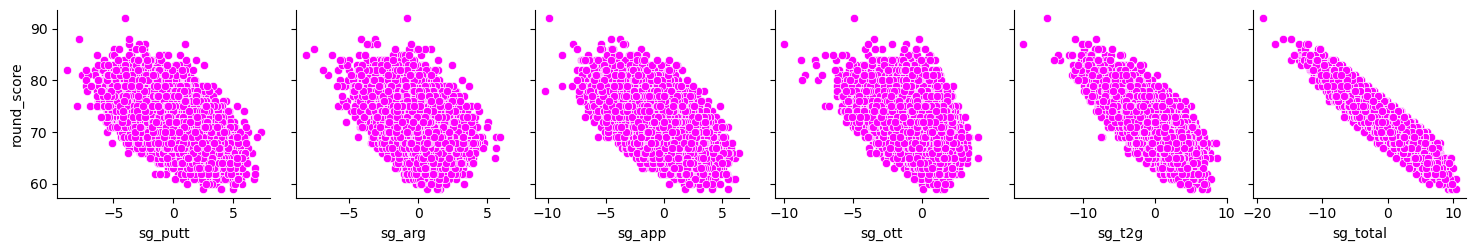

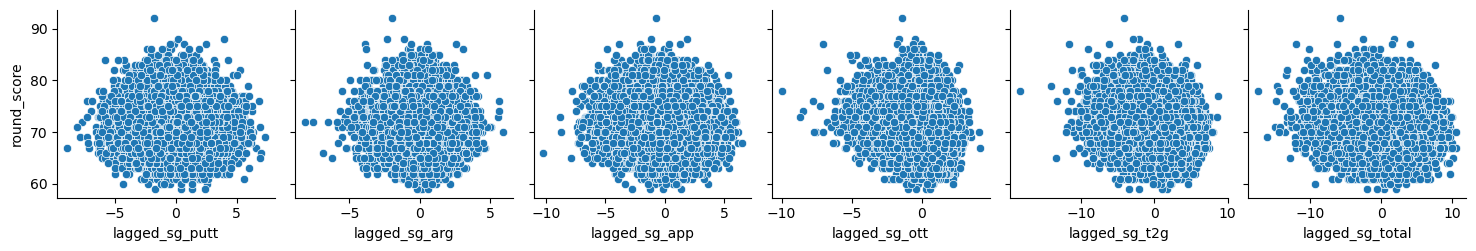

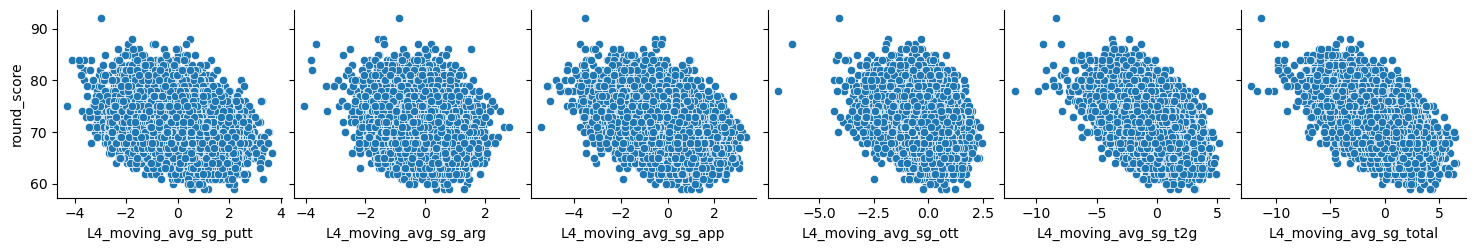

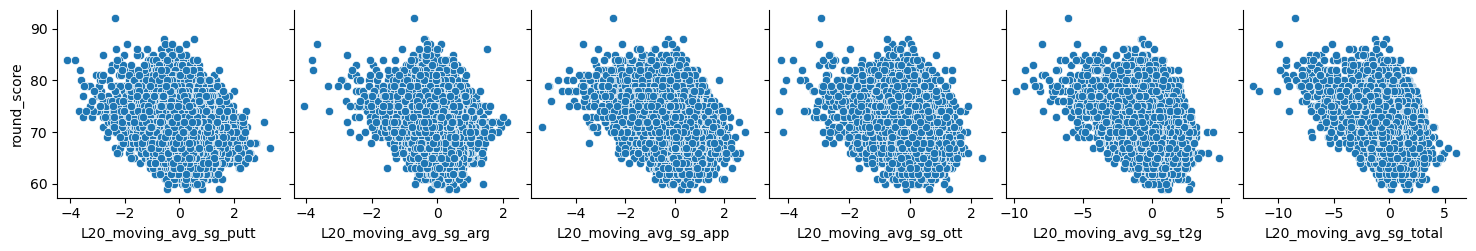

In [55]:
# Creates Seaborn Pairplots to visualize potential relationships with strokes gained statistics
sg_cols = ['sg_putt', 'sg_arg', 'sg_app', 'sg_ott', 'sg_t2g', 'sg_total']
lagged_sg_cols = ['lagged_sg_putt', 'lagged_sg_arg', 'lagged_sg_app', 'lagged_sg_ott', 'lagged_sg_t2g', 'lagged_sg_total']
L4_sg_cols = ['L4_moving_avg_sg_putt', 'L4_moving_avg_sg_arg', 'L4_moving_avg_sg_app', 'L4_moving_avg_sg_ott', 'L4_moving_avg_sg_t2g', 'L4_moving_avg_sg_total']
L20_sg_cols = ['L20_moving_avg_sg_putt', 'L20_moving_avg_sg_arg', 'L20_moving_avg_sg_app', 'L20_moving_avg_sg_ott', 'L20_moving_avg_sg_t2g', 'L20_moving_avg_sg_total']


sns.pairplot(data=train_df_sorted, x_vars=sg_cols, y_vars='round_score', plot_kws={'color': 'magenta'})
sns.pairplot(data=train_df_sorted, x_vars=lagged_sg_cols, y_vars='round_score')
sns.pairplot(data=train_df_sorted, x_vars=L4_sg_cols, y_vars='round_score')
sns.pairplot(data=train_df_sorted, x_vars=L20_sg_cols, y_vars='round_score')

The pairplots provided offer insight into the linear connections among various strokes gained statistics and their impact on a player's score. The magenta pairplot illustrates that an uptick in positive statistics inversely affects the round score, which is preferable because lower scores signify better performance in golf. By modifying the x variables to include data from the previous round, the average of the last 4 rounds, and the average of the last 20 rounds, we examine their association with the players' subsequent round scores. From this analysis, it emerges that long-term averages have a stronger correlation with future performance scores. This suggests that while professional players generally maintain consistent performance over the long haul, short-term fluctuations—represented by outlier rounds—may not be as predictive of their forthcoming scores.

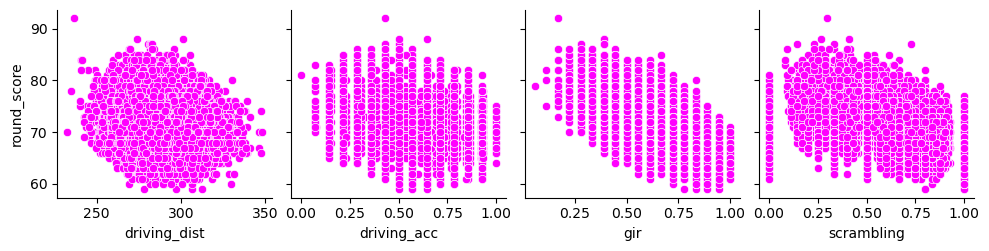

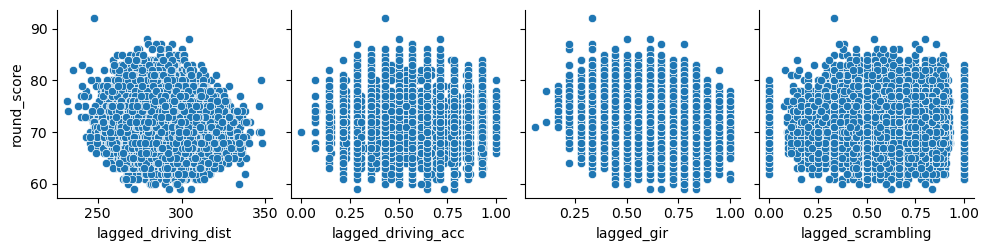

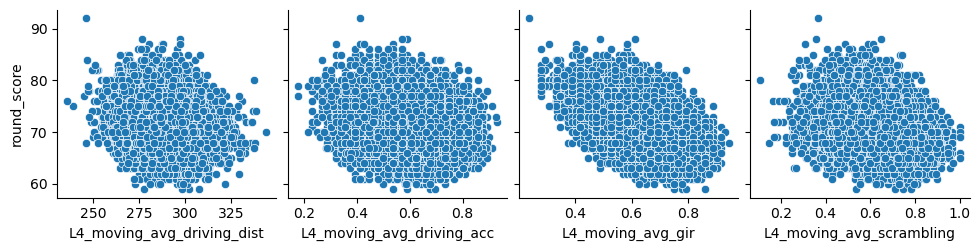

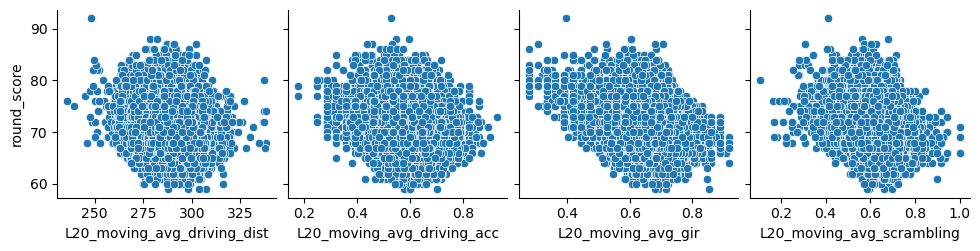

In [56]:
# Creates Seaborn Pairplots to visualize potential relationships with additional statistics
t_cols = ['driving_dist', 'driving_acc', 'gir', 'scrambling']
lagged_t_cols = ['lagged_driving_dist', 'lagged_driving_acc', 'lagged_gir', 'lagged_scrambling']
L4_t_cols = ['L4_moving_avg_driving_dist', 'L4_moving_avg_driving_acc', 'L4_moving_avg_gir', 'L4_moving_avg_scrambling']
L20_t_cols = ['L20_moving_avg_driving_dist', 'L20_moving_avg_driving_acc', 'L20_moving_avg_gir', 'L20_moving_avg_scrambling']

sns.pairplot(data=train_df_sorted, x_vars=t_cols, y_vars='round_score', plot_kws={'color': 'magenta'})
sns.pairplot(data=train_df_sorted, x_vars=lagged_t_cols, y_vars='round_score')
sns.pairplot(data=train_df_sorted, x_vars=L4_t_cols, y_vars='round_score')
sns.pairplot(data=train_df_sorted, x_vars=L20_t_cols, y_vars='round_score')

Similar to the strokes gained pairplots, we see a similar trend with these secondary statistics. The magenta pairplot illustrates that an uptick in positive statistics inversely affects the round score. By modifying the x variables to include data from the previous round, the average of the last 4 rounds, and the average of the last 20 rounds, we examine their association with the players' subsequent round scores. Again, it emerges that long-term averages have a stronger correlation with future performance scores.

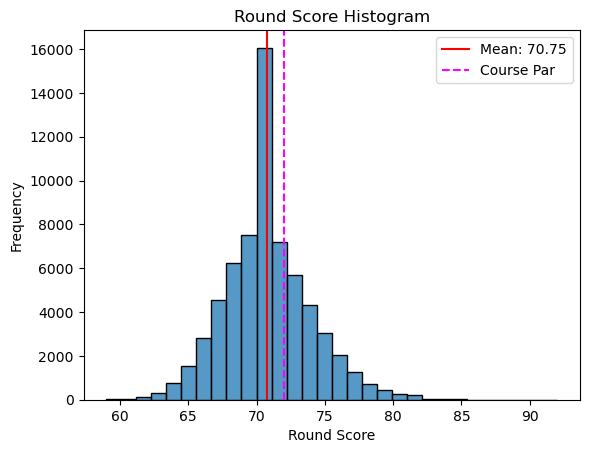

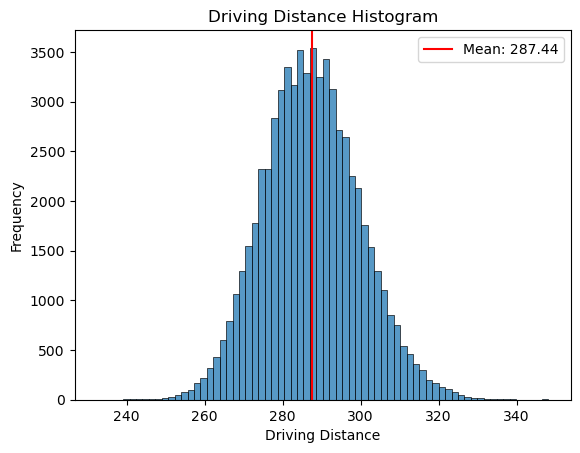

In [57]:
# Creates histograms for further analysis
sns.histplot(train_df_sorted,x='round_score', bins=30)
score_mean = train_df_sorted['round_score'].mean()
plt.axvline(score_mean, color='red', label=f'Mean: {score_mean.round(2)}')
plt.axvline(72, color='magenta', label= 'Course Par', linestyle = '--')
plt.xlabel('Round Score')
plt.ylabel('Frequency')
plt.legend()
plt.title('Round Score Histogram')
plt.savefig('Round Score Histogram.png')
plt.show()

sns.histplot(train_df_sorted,x='driving_dist', bins=70)
dist_mean = train_df_sorted['driving_dist'].mean()
plt.axvline(dist_mean, color='red', label=f'Mean: {dist_mean.round(2)}')
plt.xlabel('Driving Distance')
plt.ylabel('Frequency')
plt.legend()
plt.title('Driving Distance Histogram')
plt.savefig('Driving Distance Histogram.png')
plt.show()

We've provided 2 more important charts above that help us understand our data a bit more.
1. The first chart allows us to see the score distribution across all years of our dataset. It's clear that the mean is below the typical course par given that professional golfers tend to shoot under par more often than even or over par.
2. The second chart allows us to see the difference in driving distances. For the entire dataset, it appears the average driving distance is around 287 yards.

In [58]:
# Creates correlation dataframe to analyze top coefficients
num_stat_df = train_df_sorted.select_dtypes("number")
corr_df = num_stat_df.corr()

In [59]:
# Top 20 negative correlations with round score
corr_df['round_score'].sort_values(ascending=True).head(20)

sg_total                  -0.880827
sg_t2g                    -0.710401
gir                       -0.586754
sg_app                    -0.534475
sg_putt                   -0.529228
L4_moving_avg_sg_total    -0.508925
scrambling                -0.452078
L4_moving_avg_sg_t2g      -0.425492
L8_moving_avg_sg_total    -0.410101
L4_moving_avg_gir         -0.408302
great_shots               -0.385747
L12_moving_avg_sg_total   -0.369977
sg_ott                    -0.354556
sg_arg                    -0.351170
L8_moving_avg_sg_t2g      -0.350591
L16_moving_avg_sg_total   -0.346224
L8_moving_avg_gir         -0.338751
L20_moving_avg_sg_total   -0.332555
L4_moving_avg_sg_app      -0.329680
L12_moving_avg_sg_t2g     -0.320225
Name: round_score, dtype: float64

In [60]:
# Top 20 positive correlations with round score
corr_df['round_score'].sort_values(ascending=False).iloc[1:21]

poor_shots             0.610988
L4_moving_avg          0.601699
L4_moving_max          0.489723
L4_moving_min          0.488821
L8_moving_avg          0.476885
L12_moving_avg         0.425842
prox_fw                0.411339
L16_moving_avg         0.393760
ohe_make_cut           0.377831
L20_moving_avg         0.373021
L8_moving_min          0.349791
L8_moving_max          0.344670
career_avg             0.306009
L12_moving_min         0.299217
L12_moving_max         0.278843
L16_moving_min         0.269308
L20_moving_min         0.251401
ohe_top_five           0.240967
L16_moving_max         0.237848
lagged_ohe_make_cut    0.234706
Name: round_score, dtype: float64

The expansion of our feature set to nearly 200 dimensions presents a significant challenge for data visualization. To facilitate a deeper comprehension of the data prior to model development, we employed a coefficient analysis. This analysis identified the 40 features with the most extreme (positive and negative) coefficient values, which are indicative of their potential predictive power in subsequent models. The results of this analysis yielded some unexpected insights. While initial exploratory data analysis (EDA) led us to believe that longer-term moving averages would be more predictive, the coefficient analysis revealed a stronger influence from shorter-term averages. This underscores the importance of complementing visual analysis with quantitative methods to gain a more comprehensive understanding of complex datasets.

***

## Modelling

### Linear Regression

In [62]:
# Copy test dataset for use later in the modelling process when we want to retrieve all players most recent round to feed to our model
current_df = test_df_sorted.copy()

In [63]:
# Drop the non-numeric and non-lagged columns prior to training our model
train_df_sorted = train_df_sorted.drop(['tour','event_name','course_name','player_name','round_completed','event_completed','year'
                                        ,'season','event_completed','event_id','dg_id','round_num','course_num','course_par'
                                        ,'start_hole','sg_putt','sg_arg','sg_app','sg_ott','sg_t2g','sg_total','driving_dist'
                                        ,'driving_acc','gir','scrambling','prox_rgh','prox_fw','great_shots','poor_shots'
                                        ,'round_completed','month','day','fin_num','teetime_numeric','ohe_win','ohe_top_five'
                                        ,'ohe_top_ten','ohe_top_twenty','ohe_make_cut'], axis=1)

test_df_sorted = test_df_sorted.drop(['tour','event_name','course_name','player_name','round_completed','event_completed','year'
                                        ,'season','event_completed','event_id','dg_id','round_num','course_num','course_par'
                                        ,'start_hole','sg_putt','sg_arg','sg_app','sg_ott','sg_t2g','sg_total','driving_dist'
                                        ,'driving_acc','gir','scrambling','prox_rgh','prox_fw','great_shots','poor_shots'
                                        ,'round_completed','month','day','fin_num','teetime_numeric','ohe_win','ohe_top_five'
                                        ,'ohe_top_ten','ohe_top_twenty','ohe_make_cut'], axis=1)

In [66]:
train_df_sorted.head()

,round_score,L20_moving_avg_sg_putt,L16_moving_avg_sg_putt,L12_moving_avg_sg_putt,L8_moving_avg_sg_putt,L4_moving_avg_sg_putt,L20_moving_avg_sg_arg,L16_moving_avg_sg_arg,L12_moving_avg_sg_arg,L8_moving_avg_sg_arg,L4_moving_avg_sg_arg,L20_moving_avg_sg_app,L16_moving_avg_sg_app,L12_moving_avg_sg_app,L8_moving_avg_sg_app,L4_moving_avg_sg_app,L20_moving_avg_sg_ott,L16_moving_avg_sg_ott,L12_moving_avg_sg_ott,L8_moving_avg_sg_ott,L4_moving_avg_sg_ott,L20_moving_avg_sg_t2g,L16_moving_avg_sg_t2g,L12_moving_avg_sg_t2g,L8_moving_avg_sg_t2g,L4_moving_avg_sg_t2g,L20_moving_avg_sg_total,L16_moving_avg_sg_total,L12_moving_avg_sg_total,L8_moving_avg_sg_total,L4_moving_avg_sg_total,L20_moving_avg_driving_dist,L16_moving_avg_driving_dist,L12_moving_avg_driving_dist,L8_moving_avg_driving_dist,L4_moving_avg_driving_dist,L20_moving_avg_driving_acc,L16_moving_avg_driving_acc,L12_moving_avg_driving_acc,L8_moving_avg_driving_acc,L4_moving_avg_driving_acc,L20_moving_avg_gir,L16_moving_avg_gir,L12_moving_avg_gir,L8_moving_avg_gir,L4_moving_avg_gir,L20_moving_avg_scrambling,L16_moving_avg_scrambling,L12_moving_avg_scrambling,L8_moving_avg_scrambling,L4_moving_avg_scrambling,career_avg,L20_moving_avg,L16_moving_avg,L12_moving_avg,L8_moving_avg,L4_moving_avg,career_min,L20_moving_min,L16_moving_min,L12_moving_min,L8_moving_min,L4_moving_min,career_max,L20_moving_max,L16_moving_max,L12_moving_max,L8_moving_max,L4_moving_max,L20_round_score_std_dev,L16_round_score_std_dev,L12_round_score_std_dev,L8_round_score_std_dev,L4_round_score_std_dev,L20_sg_putt_std_dev,L16__sg_putt_std_dev,L12_putt_std_dev,L8_putt_std_dev,L4_sg_putt_std_dev,L20_sg_arg_std_dev,L16_sg_arg_std_dev,L12_sg_arg_std_dev,L8_sg_arg_std_dev,L4_sg_arg_std_dev,L20_sg_app_std_dev,L16_app_std_dev,L12_app_std_dev,L8_sg_app_std_dev,L4_sg_app_std_dev,L20_sg_ott_std_dev,L16_sg_ott_std_dev,L12_sg_ott_std_dev,L8_sg_ott_std_dev,L4_sg_ott_std_dev,L20_sg_t2g_std_dev,L16_sg_t2g_std_dev,L12_sg_t2g_std_dev,L8_sg_t2g_std_dev,L4_sg_t2g_std_dev,L20_sg_total_std_dev,L16_sg_total_std_dev,L12_sg_total_std_dev,L8_total_std_dev,L4_sg_total_std_dev,L20_driving_dist_std_dev,L16_driving_dist_std_dev,L12_driving_dist_std_dev,L8_driving_dist_std_dev,L4_driving_dist_std_dev,L20_driving_acc_std_dev,L16_driving_acc_std_dev,L12_driving_acc_std_dev,L8_driving_acc_std_dev,L4_driving_acc_std_dev,L20_gir_std_dev,L16_gir_std_dev,L12_gir_std_dev,L8_gir_std_dev,L4_gir_std_dev,L20_scrambling_std_dev,L16_scrambling_std_dev,L12_scrambling_std_dev,L8_scrambling_std_dev,L4_scrambling_std_dev,Days_Since,Last_365_Days,Last_180_Days,Last_90_Days,Last_60_Days,Last_30_Days,Last_10_Days,Last_5_Days,lagged_year,lagged_season,lagged_event_id,lagged_round_num,lagged_course_num,lagged_course_par,lagged_start_hole,lagged_round_score,lagged_sg_putt,lagged_sg_arg,lagged_sg_app,lagged_sg_ott,lagged_sg_t2g,lagged_sg_total,lagged_driving_dist,lagged_driving_acc,lagged_gir,lagged_scrambling,lagged_prox_rgh,lagged_prox_fw,lagged_great_shots,lagged_poor_shots,lagged_month,lagged_day,lagged_fin_num,lagged_teetime_numeric,lagged_ohe_win,lagged_ohe_top_five,lagged_ohe_top_ten,lagged_ohe_top_twenty,lagged_ohe_make_cut
165,70,-1.0040,-1.0040,-1.0040,-1.0040,-1.0040,-0.247000,-0.247000,-0.247000,-0.247000,-0.247000,2.057000,2.057000,2.057000,2.057000,2.057000,-0.469000,-0.469000,-0.469000,-0.469000,-0.469000,1.341000,1.341000,1.341000,1.341000,1.341000,0.3365,0.3365,0.3365,0.3365,0.3365,271.700000,271.700000,271.700000,271.700000,271.700000,0.750000,0.750000,0.750000,0.750000,0.750000,0.861000,0.861000,0.861000,0.861000,0.861000,0.875000,0.875000,0.875000,0.875000,0.875000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,66.0,66.0,66.0,66.0,66.0,66.0,70.0,70.0,70.0,70.0,70.0,70.0,2.828427,2.828427,2.828427,2.828427,2.828427,2.777515,2.777515,2.777515,2.777515,2.777515,0.178191,0.178191,0.178191,0.178191,0.178191,0.033941,0.033941,0.033941,0.033941,0.033941,0.117380,0.117380,0.117380,0.117380,0.117380,0.094752,0.094752,0.094752,0.094752,0.094752,2.8

In [69]:
# Seperates our features from our target variable
X_train = train_df_sorted.drop(['round_score'], axis=1)
y_train = train_df_sorted['round_score']

X_test = test_df_sorted.drop(['round_score'], axis=1)
y_test = test_df_sorted['round_score']

# Scales the data with a standard scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Instantiates our linear regression model
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Scores the linear regression model with our scaled train and test data
r2_train = model.score(X_train_scaled,y_train)
r2_test = model.score(X_test_scaled,y_test)

# Caclulates the mean absolute percentage error so we have another metric to evaluate our model on
X_train_pred = model.predict(X_train_scaled)
X_test_pred = model.predict(X_test_scaled)
mape_train = mean_absolute_percentage_error(X_train_pred,y_train)
mape_test = mean_absolute_percentage_error(X_test_pred,y_test)

print(f' Train: \n r2: {r2_train:.4f} \n mape: {mape_train:.4f}')
print(f' Test: \n r2: {r2_test:.4f} \n mape: {mape_test:.4f}')

 Train: 
 r2: 0.4601 
 mape: 0.0269
 Test: 
 r2: 0.4615 
 mape: 0.0270


**Model Analysis:**

Upon evaluating our initial linear regression model, it's observed that the model exhibits an R-squared value of 0.4601 for the training dataset and 0.4615 for the testing dataset. This indicates that around 46% of the variability in the outcome variable is accounted for by the model. The consistency of r^2 values between training and testing datasets suggests that the model demonstrates good generalization capabilities, without signs of overfitting or underfitting. Additionally, the Mean Absolute Percentage Error (MAPE) is calculated to be 2.69% for the training data and 2.70% for the testing data. These percentages reflect that the model's predictions deviate from the actual values by an average of approximately 2.7%, which signifies a relatively high accuracy in predictions.

### Lasso Regression

In [72]:
# Instantiates our lasso regression model
lasso_model = Lasso() 
lasso_model.fit(X_train_scaled, y_train)

# Scores the lasso regression model with our scaled train and test data
l_r2_train = lasso_model.score(X_train_scaled,y_train)
l_r2_test = lasso_model.score(X_test_scaled,y_test)

# Caclulates the mean absolute percentage error so we have another metric to evaluate our model on
l_X_train_pred = lasso_model.predict(X_train_scaled)
l_X_test_pred = lasso_model.predict(X_test_scaled)
l_mape_train = mean_absolute_percentage_error(l_X_train_pred,y_train)
l_mape_test = mean_absolute_percentage_error(l_X_test_pred,y_test)

print(f' Train: \n r2: {l_r2_train:.4f} \n mape: {l_mape_train:.4f}')
print(f' Test: \n r2: {l_r2_test:.4f} \n mape: {l_mape_test:.4f}')

 Train: 
 r2: 0.2688 
 mape: 0.0313
 Test: 
 r2: 0.2760 
 mape: 0.0313


**Model Analysis:**

By transitioning our model from linear regression to lasso regression, we aim to evaluate the impact on model performance. Lasso regression's ability to reduce certain coefficients to zero offers an opportunity to simplify the model, especially valuable considering our scenario of having engineered numerous features that might not significantly contribute to its predictive strength as initially expected. It's observed that the lasso model exhibits an R-squared value of 0.2688 for the training dataset and 0.2760 for the testing dataset. This indicates that around 27% of the variability in the outcome variable is accounted for by the model. We see a significant drop in performance here but the consistency of r^2 values between training and testing datasets suggests that the model still demonstrates good generalization capabilities. Additionally, the Mean Absolute Percentage Error (MAPE) is calculated to be 3.13% for the training data and testing data. These percentages reflect that the model's predictions deviate from the actual values by an average of approximately 3.13%, which still signifies a relatively high accuracy in predictions. Although we saw a huge performance drop, we are going to further test the viability of this model later on in our linear pipeline where we can more efficiently test different alpha values that could enhance the performance of this model.

### Ridge Regression

In [73]:
# Instantiates our ridge regression model
ridge_model = Ridge() 
ridge_model.fit(X_train_scaled, y_train)

# Scores the ridge regression model with our scaled train and test data
r_r2_train = ridge_model.score(X_train_scaled,y_train)
r_r2_test = ridge_model.score(X_test_scaled,y_test)

# Caclulates the mean absolute percentage error so we have another metric to evaluate our model on
r_X_train_pred = ridge_model.predict(X_train_scaled)
r_X_test_pred = ridge_model.predict(X_test_scaled)
r_mape_train = mean_absolute_percentage_error(r_X_train_pred,y_train)
r_mape_test = mean_absolute_percentage_error(r_X_test_pred,y_test)

print(f' Train: \n r2: {r_r2_train:.4f} \n mape: {r_mape_train:.4f}')
print(f' Test: \n r2: {r_r2_test:.4f} \n mape: {r_mape_test:.4f}')

 Train: 
 r2: 0.4600 
 mape: 0.0269
 Test: 
 r2: 0.4621 
 mape: 0.0270


**Model Analysis:**

By transitioning our model from linear regression to ridge regression, we aim to evaluate the impact on model performance. Ridge regression's ability to shrink certain coefficients but not reduce them to zero offers an opportunity to simplify the model without drastically removing potentially important features. It's observed that this model exhibits an R-squared value of 0.46 for the training dataset and 0.4621 for the testing dataset. This indicates that around 46% of the variability in the outcome variable is accounted for by the model. We see that ridge and linear produce similar results which are much better than lasso. The consistency of r^2 values between training and testing datasets suggests that the model still demonstrates good generalization capabilities. Additionally, the Mean Absolute Percentage Error (MAPE) is calculated to be 2.69% for the training data and 2.70% for the testing data. Again, we are going to further test the viability of this model later on in our linear pipeline where we can more efficiently test different alpha values that could enhance the performance of this model.

### Linear Pipeline

In [80]:
# Creates structure of our pipeline
estimators = [('scaler', StandardScaler()),
              ('reduce_dim', PCA(n_components=0.9)),
              ('model', LinearRegression())]

# Creates pipeline based on the list created above
pipe = Pipeline(estimators)

# Creates a parameter grid defining exactly what hyperparameters to search for during grid search cross-validation
param_grid = [{'scaler':[StandardScaler(), MinMaxScaler()],
               'reduce_dim':[None,PCA(n_components=0.9)],
               'model':[Lasso(max_iter=int(1e9))],
               'model__alpha':np.logspace(-3,2,50)},
              {'scaler':[StandardScaler(), MinMaxScaler()],
               'reduce_dim':[None,PCA(n_components=0.9)],
               'model':[Ridge(max_iter=int(1e9))],
               'model__alpha':np.logspace(0,10,50)},
             {'scaler':[StandardScaler(), MinMaxScaler()],
              'reduce_dim':[None,PCA(n_components=0.9)],
              'model':[LinearRegression()]}
             ]

# Sets up a grid search with the above pipeline, parameters, 5-fold cross validation, enables the use of all available CPUs, specifes the scoring metrics, and refits the final model based on the r^2 value
grid = GridSearchCV(pipe, param_grid,n_jobs=-1,verbose=20,
                    scoring=["r2","neg_mean_absolute_percentage_error"],refit='r2')

# Fits the model on the training data to determine the optimal hyperparameters
fittedgrid = grid.fit(X_train, y_train)

Fitting 5 folds for each of 404 candidates, totalling 2020 fits
[CV 2/5; 279/404] END model=Ridge(max_iter=1000000000), model__alpha=7543.120063354622, reduce_dim=PCA(n_components=0.9), scaler=StandardScaler(); neg_mean_absolute_percentage_error: (test=-0.027) r2: (test=0.433) total time=   1.6s
[CV 4/5; 281/404] START model=Ridge(max_iter=1000000000), model__alpha=12067.92640639329, reduce_dim=None, scaler=StandardScaler()
[CV 4/5; 281/404] END model=Ridge(max_iter=1000000000), model__alpha=12067.92640639329, reduce_dim=None, scaler=StandardScaler(); neg_mean_absolute_percentage_error: (test=-0.029) r2: (test=0.426) total time=   0.3s
[CV 1/5; 285/404] START model=Ridge(max_iter=1000000000), model__alpha=19306.977288832495, reduce_dim=None, scaler=StandardScaler()
[CV 1/5; 285/404] END model=Ridge(max_iter=1000000000), model__alpha=19306.977288832495, reduce_dim=None, scaler=StandardScaler(); neg_mean_absolute_percentage_error: (test=-0.027) r2: (test=0.432) total time=   0.4s
[CV 2/5

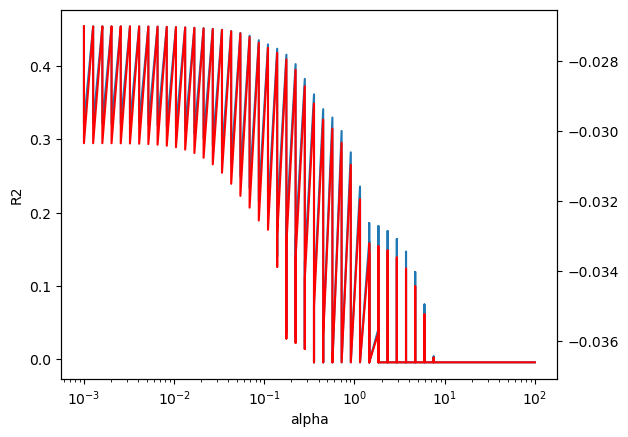

In [82]:
# Finds optimal alpha range for our lasso parameters in the pipeline
lasso_sel = results["param_model"].apply(lambda x:str(x).startswith("Lasso"))
lasso_results = results.loc[lasso_sel,["param_model__alpha","mean_test_r2","mean_test_neg_mean_absolute_percentage_error"]]
plt.figure()
plt.plot(lasso_results["param_model__alpha"],lasso_results["mean_test_r2"])
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("R2")
ax2 = plt.gca().twinx()
ax2.plot(lasso_results["param_model__alpha"],lasso_results["mean_test_neg_mean_absolute_percentage_error"],color='red')

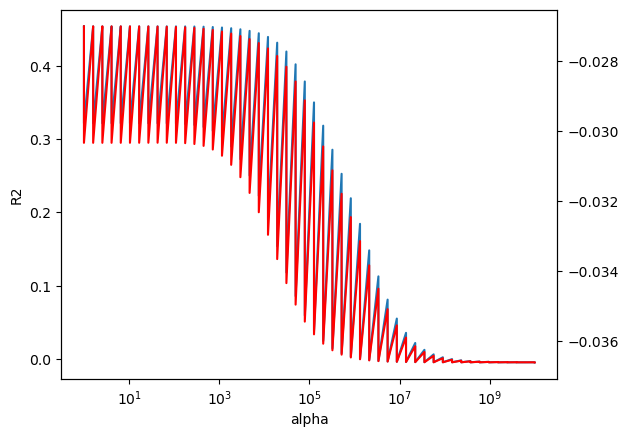

In [83]:
# Finds optimal alpha range for our ridge parameters in the pipeline
ridge_sel = results["param_model"].apply(lambda x:str(x).startswith("Ridge"))
ridge_results = results.loc[ridge_sel,["param_model__alpha","mean_test_r2","mean_test_neg_mean_absolute_percentage_error"]]
plt.figure()
plt.plot(ridge_results["param_model__alpha"],ridge_results["mean_test_r2"])
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("R2")
ax2 = plt.gca().twinx()
ax2.plot(ridge_results["param_model__alpha"],ridge_results["mean_test_neg_mean_absolute_percentage_error"],color='red')

The two charts above were employed to identify the ideal range for testing various alpha values in both Lasso and Ridge regression models.

In [87]:
# Retrieves best model from our grid search
fittedgrid.best_estimator_.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ('reduce_dim', None),
  ('model', Lasso(alpha=0.0020235896477251575, max_iter=1000000000))],
 'verbose': False,
 'scaler': StandardScaler(),
 'reduce_dim': None,
 'model': Lasso(alpha=0.0020235896477251575, max_iter=1000000000),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'model__alpha': 0.0020235896477251575,
 'model__copy_X': True,
 'model__fit_intercept': True,
 'model__max_iter': 1000000000,
 'model__normalize': False,
 'model__positive': False,
 'model__precompute': False,
 'model__random_state': None,
 'model__selection': 'cyclic',
 'model__tol': 0.0001,
 'model__warm_start': False}

In [89]:
# Calculates the r^2 of our test data, using the optimal model returned from the grid search
fittedgrid.best_estimator_.score(X_test,y_test)

0.4622443513957877

**Model Analysis:**

Through the application of a pipeline combined with grid search cross-validation, we successfully assessed various preprocessing and modeling options to identify the optimal configuration. Our exploration covered a range of parameters, including the choice between StandardScaler and MinMaxScaler for scaling, the decision to use PCA or bypass it for dimensionality reduction, different alpha values, and three distinct models previously mentioned. The outcome of this process revealed that the most effective model is a Lasso regression, characterized by an alpha value of 0.002, employing a StandardScaler for data normalization, and opting out of PCA for dimensionality reduction. This model achieved an R-squared value of 0.4622 on the test data, which signifies that it can explain approximately 46% of the variance in the dependent variable.

### Random Forest Regressor

In [90]:
# Creates structure of our pipeline
estimators2 = [('scaler', StandardScaler()),
              ('reduce_dim', PCA(n_components=0.9)),
              ('model', RandomForestRegressor())]

# Creates pipeline based on the list created above
pipe2 = Pipeline(estimators2)

# Creates a parameter grid defining exactly what hyperparameters to search for during grid search cross-validation
param_grid2 = [{'scaler': [StandardScaler(), MinMaxScaler()],
                'reduce_dim': [None, PCA(n_components=0.9)],
                'model':[RandomForestRegressor()],
                'model__max_depth':[5,10,15,20,25]}
              ]

# Sets up a grid search with the above pipeline, parameters, 5-fold cross validation, enables the use of all available CPUs, specifes the scoring metrics, and refits the final model based on the r^2 value
grid2 = GridSearchCV(pipe2, param_grid2, cv=5,verbose=20,n_jobs=-1,
                    scoring=["r2","neg_mean_absolute_percentage_error"],refit='r2')

# Fits the model on the training data to determine the optimal hyperparameters
fittedgrid2 = grid2.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5; 1/20] START model=RandomForestRegressor(), model__max_depth=5, reduce_dim=None, scaler=StandardScaler()
[CV 1/5; 1/20] END model=RandomForestRegressor(), model__max_depth=5, reduce_dim=None, scaler=StandardScaler(); neg_mean_absolute_percentage_error: (test=-0.028) r2: (test=0.417) total time= 2.9min
[CV 1/5; 4/20] START model=RandomForestRegressor(), model__max_depth=5, reduce_dim=PCA(n_components=0.9), scaler=MinMaxScaler()
[CV 1/5; 4/20] END model=RandomForestRegressor(), model__max_depth=5, reduce_dim=PCA(n_components=0.9), scaler=MinMaxScaler(); neg_mean_absolute_percentage_error: (test=-0.031) r2: (test=0.262) total time=  47.7s
[CV 3/5; 6/20] START model=RandomForestRegressor(), model__max_depth=10, reduce_dim=None, scaler=MinMaxScaler()
[CV 3/5; 6/20] END model=RandomForestRegressor(), model__max_depth=10, reduce_dim=None, scaler=MinMaxScaler(); neg_mean_absolute_percentage_error: (test=-0.025) r2: (test=0.4

In [91]:
results2 = pd.DataFrame(fittedgrid2.cv_results_)

In [92]:
results2[["param_scaler","param_reduce_dim","param_model__max_depth","mean_test_r2"]]

,param_scaler,param_reduce_dim,param_model__max_depth,mean_test_r2
0,StandardScaler(),None,5,0.414161
1,MinMaxScaler(),None,5,0.413820
2,StandardScaler(),PCA(n_components=0.9),5,0.277917
3,MinMaxScaler(),PCA(n_components=0.9),5,0.250491
4,StandardScaler(),None,10,0.496909
5,MinMaxScaler(),None,10,0.497245
6,StandardScaler(),PCA(n_components=0.9),10,0.355950
7,MinMaxScaler(),PCA(n_components=0.9),10,0.342415
8,StandardScaler(),None,15,0.511574
9,MinMaxScaler(),None,15,0.510219


In [93]:
fittedgrid2.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()), ('reduce_dim', None),
                ('model', RandomForestRegressor(max_depth=15))])

In [94]:
fittedgrid2.best_estimator_.score(X_test,y_test)

0.5246167718437944

**Model Analysis:**

Upon executing a random forest regressor pipeline, we observed an approximate 6% enhancement in our r^2 value. This signifies that the model now explains about 52.5% of the variation in the dependent variable, marking a significant improvement over our prior linear models. However, the primary drawback of employing this model lies in its substantial computational demands and the extended duration needed for training. Despite leveraging all available CPU cores, training times exceed 30 minutes and are expected to increase with the addition of more data for a relatively modest improvement in r^2. In summary, while the increase in r^2 is good, it comes at the expense of considerable computational resources and time.

### Neural Network

In [114]:
# Scales the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [115]:
# Instantiates Keras Neural Network
model = keras.Sequential()

# Creates a regularizer with a factor of 0.001 and apply it to all hidden layers
regularizer = keras.regularizers.l1(0.001)

# Declares the hidden layers
model.add(layers.Dense(40, activation="relu", kernel_regularizer=regularizer))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(40, activation="relu", kernel_regularizer=regularizer))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(40, activation="relu", kernel_regularizer=regularizer))
model.add(layers.Dropout(0.1))

# Declares the output layer
model.add(layers.Dense(1))

# Compiles the model
model.compile(
    # Optimizer
    optimizer=keras.optimizers.Adam(),
    # Loss function to minimize
    loss=keras.losses.MeanSquaredError()
)

history = model.fit(X_train_scaled, y_train, epochs=150, verbose=1)

Epoch 1/150
2042/2042 [==============================] - 1s 326us/step - loss: 262.2708
Epoch 2/150
2042/2042 [==============================] - 1s 321us/step - loss: 53.3351
Epoch 3/150
2042/2042 [==============================] - 1s 321us/step - loss: 43.3795
Epoch 4/150
2042/2042 [==============================] - 1s 320us/step - loss: 39.4823
Epoch 5/150
2042/2042 [==============================] - 1s 321us/step - loss: 36.6559
Epoch 6/150
2042/2042 [==============================] - 1s 320us/step - loss: 33.8344
Epoch 7/150
2042/2042 [==============================] - 1s 319us/step - loss: 31.5823
Epoch 8/150
2042/2042 [==============================] - 1s 320us/step - loss: 29.3742
Epoch 9/150
2042/2042 [==============================] - 1s 320us/step - loss: 27.6579
Epoch 10/150
2042/2042 [==============================] - 1s 321us/step - loss: 26.1312
Epoch 11/150
2042/2042 [==============================] - 1s 320us/step - loss: 25.4112
Epoch 12/150
2042/2042 [================

In [116]:
# Evaluate the model using the test data and generate predictions
train_loss = history.history["loss"][-1]
result = model.evaluate(X_test_scaled, y_test, verbose=0)

print(f"Train Loss: {train_loss:.4f}")
print(f"Test Loss: {result:.4f}")

y_pred_nn = model.predict(X_test_scaled)

Train Loss: 4.5877
Test Loss: 4.5769


In [132]:
r2_score(y_test,y_pred_nn)

0.6343541963177219

**Model Analysis:**

After implementing a Keras sequential neural network, we noted an 18% increase in our r^2 value. This improvement means the model accounts for roughly 64% of the variance in the target variable, a substantial leap from the performance of our previous linear models. Moreover, this model operates within an acceptable timeframe and offers enhanced flexibility for customization and fine-tuning. Given these advantages, we've identified it as the most viable option available. Our future efforts will be concentrated on optimizing this model further, as it demonstrates the highest overall performance.

***

## Model Projections

In [118]:
# Retrieves every players most recent record
sorted_df = current_df.sort_values(by=['dg_id', 'round_completed'])
most_recent_scores = sorted_df.drop_duplicates(subset='dg_id', keep='last').reset_index(drop=True)

In [119]:
# Drops the necessary columns prior to feeding the dataframe into our model
most_recent_scores = most_recent_scores.drop(['tour','event_name','course_name','player_name','round_completed','event_completed','year'
                                        ,'season','event_completed','event_id','round_num','course_num','course_par'
                                        ,'start_hole','sg_putt','sg_arg','sg_app','sg_ott','sg_t2g','sg_total','driving_dist'
                                        ,'driving_acc','gir','scrambling','prox_rgh','prox_fw','great_shots','poor_shots'
                                        ,'round_completed','month','day','fin_num','teetime_numeric','ohe_win','ohe_top_five'
                                        ,'ohe_top_ten','ohe_top_twenty','ohe_make_cut'], axis=1)

In [120]:
# Removes player IDs before modelling
preserved_ids = most_recent_scores[['dg_id']].copy()
most_recent_scores = most_recent_scores.drop(['dg_id','round_score'], axis=1)

In [121]:
# Predicts each players score
mr_scaled = scaler.transform(most_recent_scores)
predicted_score = model.predict(mr_scaled)
print(predicted_score)

[[81.557846]
 [73.390915]
 [76.775215]
 [73.56512 ]
 [78.969   ]
 [77.37435 ]
 [73.12149 ]
 [74.29815 ]
 [75.164536]
 [73.71907 ]
 [70.22122 ]
 [73.854645]
 [76.86546 ]
 [73.874405]
 [80.07564 ]
 [76.20729 ]
 [69.48451 ]
 [75.172745]
 [78.612274]
 [77.26116 ]
 [78.32056 ]
 [73.739174]
 [70.43897 ]
 [71.42681 ]
 [74.47268 ]
 [77.248604]
 [75.72918 ]
 [75.0909  ]
 [72.9802  ]
 [72.77056 ]
 [75.21601 ]
 [70.63215 ]
 [75.9556  ]
 [74.038635]
 [71.973564]
 [70.874   ]
 [70.71648 ]
 [68.65526 ]
 [71.8659  ]
 [74.38074 ]
 [73.895905]
 [70.343094]
 [72.35791 ]
 [73.60161 ]
 [73.16607 ]
 [76.51479 ]
 [73.30156 ]
 [74.95695 ]
 [70.992485]
 [78.08595 ]
 [65.37834 ]
 [71.12396 ]
 [72.90358 ]
 [74.871414]
 [71.88519 ]
 [73.87366 ]
 [70.052376]
 [71.706406]
 [74.34558 ]
 [71.72953 ]
 [74.190994]
 [73.51372 ]
 [75.51021 ]
 [72.80386 ]
 [71.619225]
 [71.71271 ]
 [67.65357 ]
 [69.844826]
 [72.15222 ]
 [67.783714]
 [73.498344]
 [69.446304]
 [72.0765  ]
 [70.85315 ]
 [74.67151 ]
 [65.59219 ]
 [72.52267 ]

In [133]:
# Merges player IDs back onto the predictions and joins with the field dataframe so we only get the score predictions for players competing in the tournament this week
preserved_ids['predicted_score'] = predicted_score
result_df = preserved_ids.merge(player_df[['dg_id', 'player_name']], on='dg_id', how='left')
this_week_df = result_df.merge(field_df[['dg_id', 'event_name']], on='dg_id', how='inner')
this_week_df.sort_values(by='predicted_score', ascending=True).head(10)

,dg_id,predicted_score,player_name,event_name
101,19872,66.871704,"Riley, Davis",Valero Texas Open
148,28469,66.893257,"Highsmith, Joe",Valero Texas Open
73,17032,67.257202,"Tosti, Alejandro",Valero Texas Open
30,11276,67.554977,"Horschel, Billy",Valero Texas Open
24,10419,67.608780,"Noren, Alex",Valero Texas Open
67,16333,67.885406,"Hubbard, Mark",Valero Texas Open
41,13508,67.950523,"Vegas, Jhonattan",Valero Texas Open
87,18103,67.957863,"Bezuidenhout, Christiaan",Valero Texas Open
116,23465,68.155609,"Greyserman, Max",Valero Texas Open
52,14577,68.192047,"English, Harris",Valero Texas Open


***

## Conclusion

Having successfully refined our project's focus, meticulously preprocessed our data, created numerous new features, advanced our exploratory data analysis (EDA), and experimented with several machine learning models, we've identified the neural network model as the top performer. It will be the centerpiece of our efforts moving forward. To further validate its effectiveness, we've used it to predict the next round scores for players in the upcoming week's tournament, serving as a practical demonstration of its capability to generate outcomes relevant to real-world scenarios. Our next pivotal task involves fine-tuning this model to enhance its precision. Once optimized, we plan to apply it across various contexts, including predicting scores for individual rounds (As shown above) and entire tournaments, as well as forecasting outcomes of head-to-head matchups. The final goal is to encapsulate this functionality within a Streamlit application, making it accessible for consumer use.

***

## Citations

#### Links:
    - https://docs.python.org/3/library/datetime.html
    - https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_datetime.html
    - https://github.com/mwaskom/seaborn/issues/2726
#### ChatGPT Prompts:
    - "How to create rolling average functions in pandas dataframes?"
    - "Subtracting an integer from a date column in pandas based on conditions where we would use nested ifs"
    - "What is the following warning: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`"
    - "How to retrieve the last instance of a record in pandas dataframe based on specific criteria?"

***